# Описание проекта

По данным Минобрнауки РФ в этом году более 6,5 млн. человек
подали заявление на зачисление в учебное заведение. В 2022 г. количество
бюджетных мест увеличилось до 588 044, большинство из них — в
региональных университетах.
Высшее образование имеет большое значение для формирования
карьерной траектории. На сегодняшний день в России около 700 вузов
предоставляют возможность обучения по образовательным программам в
различных направлениях. После школы или колледжа молодые люди
выбирают, в какой сфере хотят развиваться. И, конечно, каждый будущий
студент хочет получить действительно качественное и разностороннее
образование.
Ежегодно тысячи абитуриентов в нашей стране участвуют в приемной
кампании, выбирая себе будущую профессию или дополнительные знания и
навыки, чтобы повысить свои профессиональные компетенции и стать
востребованным специалистом. Но все ли студенты заканчивают
университет?
Перед участниками чемпионата стоит задача предсказать будущий
потенциальный статус студента на основе данных нескольких тысяч
студентов. Такая прогнозная модель может стать хорошим инструментом
при планировании учебной работы в вузах, взаимодействии с
работодателями или реализации научных проектов.

# Предобработка данных

In [5]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score, make_scorer, f1_score

import warnings
warnings.filterwarnings("ignore")

from tqdm import notebook

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



import optuna
from optuna.samplers import TPESampler, GridSampler

#from optuna.visualization import plot_optimization_history
#from optuna.visualization import plot_param_importances

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle

from pymystem3 import Mystem


from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [9]:
# Снимем ограничение на количество выводимых столбцов
pd.set_option('display.max_columns', None)

# Снимем ограничение на количество выводимых строк
pd.set_option('display.max_rows', None)


In [10]:
train = pd.read_csv('/content/sample_data/train_dataset_train.csv')
test = pd.read_csv('/content/sample_data/test_dataset_test.csv')

In [11]:
train.head()

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,Страна_ПП,Регион_ПП,Город_ПП,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08 00:00:00.000,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18 00:00:00.000,NaN,NaN,NaN,0.0,Россия,Алтайский край,Барнаул г,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21 00:00:00.000,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,0.0,Россия,Алтайский край,Алтайское с,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4
3,81661,19838,2017,Жен,БН,Английский язык,1994-12-08 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4
4,81509,19803,2017,Жен,БН,Английский язык,1995-06-28 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4


In [12]:
test.head()

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,Страна_ПП,Регион_ПП,Город_ПП,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата
0,64996,20608,2014,Жен,ДН,Английский язык,1995-11-03 00:00:00.000,"МБОУ ""СОШ №55""","Алтайский край, Барнаул г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,40.0,49.0
1,71837,20613,2015,Жен,ДН,Немецкий язык,1995-12-10 00:00:00.000,"МБОУ ""СОШ №1""","Алтайский край, Рубцовск г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,1.0,0.0,26.0,77.0
2,86587,21210,2018,Жен,ОО,Английский язык,1973-08-09 00:00:00.000,Алтайский государственный медицинский университет,"Алтайский край, г. Барнаул",1997.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,34.0,74.0
3,73673,22254,2015,Жен,ОО,Английский язык,1983-12-07 00:00:00.000,"ГОУ ВПО ""Алтайский государственный университет""","Алтайский край, Барнаул г",2006.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,53.0,57.0
4,54709,15040,2012,Жен,ОО,NaN,1994-05-21 00:00:00.000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1,1.0,Россия,0.0,0.0,0.0,36.0,55.0


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                13584 non-null  int64  
 1   Код_группы        13584 non-null  int64  
 2   Год_Поступления   13584 non-null  int64  
 3   Пол               13577 non-null  object 
 4   Основания         13584 non-null  object 
 5   Изучаемый_Язык    12758 non-null  object 
 6   Дата_Рождения     13584 non-null  object 
 7   Уч_Заведение      12351 non-null  object 
 8   Где_Находится_УЗ  12203 non-null  object 
 9   Год_Окончания_УЗ  12284 non-null  float64
 10  Пособие           12576 non-null  float64
 11  Страна_ПП         13237 non-null  object 
 12  Регион_ПП         12966 non-null  object 
 13  Город_ПП          13141 non-null  object 
 14  Общежитие         13498 non-null  float64
 15  Наличие_Матери    13584 non-null  int64  
 16  Наличие_Отца      13584 non-null  float6

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                6691 non-null   int64  
 1   Код_группы        6691 non-null   int64  
 2   Год_Поступления   6691 non-null   int64  
 3   Пол               6688 non-null   object 
 4   Основания         6691 non-null   object 
 5   Изучаемый_Язык    6295 non-null   object 
 6   Дата_Рождения     6691 non-null   object 
 7   Уч_Заведение      6113 non-null   object 
 8   Где_Находится_УЗ  6031 non-null   object 
 9   Год_Окончания_УЗ  6074 non-null   float64
 10  Пособие           6207 non-null   float64
 11  Страна_ПП         6531 non-null   object 
 12  Регион_ПП         6401 non-null   object 
 13  Город_ПП          6477 non-null   object 
 14  Общежитие         6656 non-null   float64
 15  Наличие_Матери    6691 non-null   int64  
 16  Наличие_Отца      6691 non-null   float64


In [15]:
# Напишем функцию которая будет выводит долю пропусков с сортировкой по убыванию

def data_omissions(data):
    return pd.DataFrame(
        data
        .isna()
        .mean()
        .round(4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

In [16]:
# Посмотрим на величину пропусков в процентном выражении
data_omissions(train)

,0
Где_Находится_УЗ,10.170000
Год_Окончания_УЗ,9.570000
Уч_Заведение,9.080000
Пособие,7.420000
Изучаемый_Язык,6.080000
Регион_ПП,4.550000
Страна_Родители,3.370000
Город_ПП,3.260000
Страна_ПП,2.550000
Иностранец,2.280000


In [17]:
# Посмотрим на величину пропусков в процентном выражении
data_omissions(test)

,0
Где_Находится_УЗ,9.860000
Год_Окончания_УЗ,9.220000
Уч_Заведение,8.640000
Пособие,7.230000
Изучаемый_Язык,5.920000
Регион_ПП,4.330000
Город_ПП,3.200000
Страна_Родители,2.960000
Страна_ПП,2.390000
Иностранец,1.940000


1. Столбец ID для обучения использовать не будем;
2. Названия столбцов приведём к нижнему регистру и к стилю написания snake_case;
3. Изменить тип данных в некоторых столбцах на int, а именно Год_Окончания_УЗ, Пособие, Общежитие, Наличие_Отца, Опекунство, Село, Иностранец.
4. И конечно данные содержат пропуски.

## Редактирование названий столбцов

In [18]:
# Изменим назавание столбца 'customer_i_d'
train.rename(columns={
    'КодФакультета': 'код_факультета', 
    'СрБаллАттестата': 'ср_балл_аттестата'}, inplace=True)

In [19]:
# Изменим назавание столбца 'customer_i_d'
test.rename(columns={
    'КодФакультета': 'код_факультета', 
    'СрБаллАттестата': 'ср_балл_аттестата'}, inplace=True)

In [20]:
train.columns = list(map(lambda x: x.lower() , train.columns))
train.columns

Index(['id', 'код_группы', 'год_поступления', 'пол', 'основания',
       'изучаемый_язык', 'дата_рождения', 'уч_заведение', 'где_находится_уз',
       'год_окончания_уз', 'пособие', 'страна_пп', 'регион_пп', 'город_пп',
       'общежитие', 'наличие_матери', 'наличие_отца', 'страна_родители',
       'опекунство', 'село', 'иностранец', 'код_факультета',
       'ср_балл_аттестата', 'статус'],
      dtype='object')

In [21]:
test.columns = list(map(lambda x: x.lower() , test.columns))
test.columns

Index(['id', 'код_группы', 'год_поступления', 'пол', 'основания',
       'изучаемый_язык', 'дата_рождения', 'уч_заведение', 'где_находится_уз',
       'год_окончания_уз', 'пособие', 'страна_пп', 'регион_пп', 'город_пп',
       'общежитие', 'наличие_матери', 'наличие_отца', 'страна_родители',
       'опекунство', 'село', 'иностранец', 'код_факультета',
       'ср_балл_аттестата'],
      dtype='object')

## id

In [22]:
train.drop(['id'], axis=1, inplace=True)
train.head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,город_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус
0,16019,2015,Жен,ОО,Английский язык,1998-02-08 00:00:00.000,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,14895,2010,Муж,ЦН,NaN,1992-04-18 00:00:00.000,NaN,NaN,NaN,0.0,Россия,Алтайский край,Барнаул г,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,20103,2017,Жен,ДН,Английский язык,1999-03-21 00:00:00.000,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,0.0,Россия,Алтайский край,Алтайское с,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4
3,19838,2017,Жен,БН,Английский язык,1994-12-08 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4
4,19803,2017,Жен,БН,Английский язык,1995-06-28 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4


In [23]:
test.drop(['id'], axis=1, inplace=True)
test.head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,город_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата
0,20608,2014,Жен,ДН,Английский язык,1995-11-03 00:00:00.000,"МБОУ ""СОШ №55""","Алтайский край, Барнаул г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,40.0,49.0
1,20613,2015,Жен,ДН,Немецкий язык,1995-12-10 00:00:00.000,"МБОУ ""СОШ №1""","Алтайский край, Рубцовск г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,1.0,0.0,26.0,77.0
2,21210,2018,Жен,ОО,Английский язык,1973-08-09 00:00:00.000,Алтайский государственный медицинский университет,"Алтайский край, г. Барнаул",1997.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,34.0,74.0
3,22254,2015,Жен,ОО,Английский язык,1983-12-07 00:00:00.000,"ГОУ ВПО ""Алтайский государственный университет""","Алтайский край, Барнаул г",2006.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,53.0,57.0
4,15040,2012,Жен,ОО,NaN,1994-05-21 00:00:00.000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1,1.0,Россия,0.0,0.0,0.0,36.0,55.0


## код_группы

In [24]:
train['код_группы'].value_counts()

14705    23
20657    23
20698    22
20939    22
18540    21
21236    20
19444    20
19429    20
17115    20
15096    20
21753    20
17116    20
20604    19
20603    19
19699    19
18725    19
18150    19
17038    19
20623    19
17037    19
20723    19
17117    18
20656    18
15536    18
17112    18
20652    18
20089    18
21757    18
14665    18
18216    18
21237    18
14809    17
20651    17
18723    17
18208    17
19397    17
20659    17
19430    17
20642    17
20880    17
17113    17
14708    17
19783    17
17194    17
16894    17
17450    17
19330    17
20666    17
19465    17
16888    17
17435    17
19504    17
18227    17
20628    17
19425    16
19437    16
20923    16
19915    16
14662    16
21756    16
18735    16
17110    16
19468    16
21209    16
15166    16
18317    16
17114    16
20891    16
20889    16
18319    16
20649    16
20599    16
20722    16
20344    16
17040    16
20887    15
20643    15
16860    15
19974    15
16912    15
15233    15
20924    15
19469    15
1832

## год_поступления

In [25]:
train['год_поступления'].value_counts()

2015    2353
2014    2290
2016    2271
2013    2070
2017    1460
2012    1394
2018    1147
2019     466
2020      48
2011      46
2010      19
2009       8
2007       5
2008       2
2212       1
2001       1
2004       1
2005       1
2003       1
Name: год_поступления, dtype: int64

In [26]:
train['год_поступления'].unique()

array([2015, 2010, 2017, 2013, 2014, 2016, 2018, 2012, 2019, 2020, 2212,
       2011, 2009, 2007, 2008, 2001, 2004, 2005, 2003])

In [27]:
train.query('год_поступления == 2212')

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,город_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус
104,11576,2212,Муж,СН,Английский язык,1991-07-22 00:00:00.000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1,1.0,NaN,0.0,0.0,0.0,25.0,43.0,3


In [28]:
train.drop(train.query('год_поступления == 2212').index, inplace=True)

In [29]:
train['год_поступления'].unique()

array([2015, 2010, 2017, 2013, 2014, 2016, 2018, 2012, 2019, 2020, 2011,
       2009, 2007, 2008, 2001, 2004, 2005, 2003])

In [30]:
test['год_поступления'].unique()

array([2014, 2015, 2018, 2012, 2013, 2016, 2019, 2017, 2011, 2020, 2010,
       2009, 2007, 2006])

## пол

In [31]:
train['пол'].isna().sum()

7

In [32]:
train[train['пол'].isna()]

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,город_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус
1734,17194,2015,NaN,СН,Английский язык,1994-11-22 00:00:00.000,СШ № 37,"Китай, Аньян г",2015.0,NaN,Китай,Хэнань провинция,Аньян г,1.0,0,0.0,Китай,0.0,0.0,1.0,24.0,45.0,3
2322,16008,2015,NaN,ДН,Английский язык,1995-11-08 00:00:00.000,средняя школа № 1 города Муданьцзян,"Китай, Муданьцзян г.",2013.0,NaN,Китай,NaN,Шэньян г,1.0,0,0.0,Китай,0.0,0.0,1.0,51.0,46.0,3
4235,18499,2016,NaN,СН,Английский язык,1996-07-03 00:00:00.000,Средняя школа уезда Наньсянь провинции Сычуань,"Китай, провинция Сычуань, городской округ Мяньян",2014.0,0.0,Китай,Сычуань провинция,Мяньян городской округ,1.0,1,1.0,Китай,0.0,0.0,1.0,24.0,40.0,3
5864,18499,2016,NaN,СН,Английский язык,1996-03-04 00:00:00.000,Средняя школа №8 города Далянь,"Китай, г Далянь",2014.0,0.0,Китай,Ляонин провинция,Далянь г,1.0,1,1.0,Китай,0.0,0.0,1.0,24.0,40.0,4
9881,21006,2018,NaN,БН,NaN,1997-03-15 00:00:00.000,Восточно-Казахстанский государственный универс...,"Казахстан, Восточно-Казахстанская область, г. ...",2018.0,0.0,Казахстан,Восточно-Казахстанская область,г. Усть-Каменогорск,1.0,1,1.0,Казахстан,0.0,0.0,1.0,27.0,70.0,4
12448,18499,2016,NaN,СН,Английский язык,1996-10-25 00:00:00.000,СШ № 4 г. Цзиньчан,"Китай, провинция Ганьсу, городской округ Цзиньчан",2014.0,0.0,Китай,пров. Ганьсу,гор. округ Цзиньчан,1.0,1,1.0,Китай,0.0,0.0,1.0,24.0,42.0,3
13271,15447,2014,NaN,СН,Английский язык,1983-08-20 00:00:00.000,Синцзянский финансово-экономический университет,"Китай, Синьцзянь",2007.0,NaN,Россия,Алтайский край,Барнаул г,1.0,0,0.0,КНР,0.0,0.0,1.0,24.0,78.0,4


In [33]:
#train.dropna(subset=['пол'], inplace=True)
train['пол'] = train['пол'].fillna('unknow')

In [34]:
#test.dropna(subset=['пол'], inplace=True)
test['пол'] = test['пол'].fillna('unknow')

In [35]:
train['пол'] = train['пол'].str.lower()
test['пол'] = test['пол'].str.lower()

In [36]:
train['пол'].value_counts()

жен       8133
муж       5443
unknow       7
Name: пол, dtype: int64

In [37]:
test['пол'].value_counts()

жен       3975
муж       2713
unknow       3
Name: пол, dtype: int64

In [38]:
# Посмотрим на величину пропусков в процентном выражении
data_omissions(train)

,0
где_находится_уз,10.160000
год_окончания_уз,9.560000
уч_заведение,9.070000
пособие,7.420000
изучаемый_язык,6.080000
регион_пп,4.540000
страна_родители,3.360000
город_пп,3.250000
страна_пп,2.550000
иностранец,2.280000


In [39]:
# Посмотрим на величину пропусков в процентном выражении
data_omissions(test)

,0
где_находится_уз,9.860000
год_окончания_уз,9.220000
уч_заведение,8.640000
пособие,7.230000
изучаемый_язык,5.920000
регион_пп,4.330000
город_пп,3.200000
страна_родители,2.960000
страна_пп,2.390000
иностранец,1.940000


## основания

In [40]:
train['основания'].unique()

array(['ОО', 'ЦН', 'ДН', 'БН', 'СН'], dtype=object)

In [41]:
train['основания'].value_counts()

ОО    5084
СН    4557
БН    1882
ДН    1853
ЦН     207
Name: основания, dtype: int64

In [42]:
test['основания'].unique()

array(['ДН', 'ОО', 'СН', 'БН', 'ЦН', 'ЛН'], dtype=object)

In [43]:
test['основания'].value_counts()

ОО    2565
СН    2177
ДН     972
БН     873
ЦН     103
ЛН       1
Name: основания, dtype: int64

In [44]:
test.loc[1505, 'основания'] = 'БН'

In [45]:
test['основания'].value_counts()

ОО    2565
СН    2177
ДН     972
БН     874
ЦН     103
Name: основания, dtype: int64

## изучаемый_язык

In [46]:
train['изучаемый_язык'].unique()

array(['Английский язык', nan, 'Немецкий язык', 'Французский язык',
       'Русский язык', 'Иностранный язык (Английский)',
       'Иностранный язык (Немецкий)', 'Англиийский'], dtype=object)

Пропуски и неявные дубликаты. Пропуски составляют 6%, что является уже не малым значением.

In [47]:
train['изучаемый_язык'].value_counts()

Английский язык                  10449
Немецкий язык                     2219
Французский язык                    54
Русский язык                        11
Иностранный язык (Английский)       10
Англиийский                         10
Иностранный язык (Немецкий)          4
Name: изучаемый_язык, dtype: int64

In [48]:
test['изучаемый_язык'].value_counts()

Английский язык                  5202
Немецкий язык                    1047
Французский язык                   28
Англиийский                         8
Иностранный язык (Английский)       8
Русский язык                        1
Английский, немецкий языки          1
Name: изучаемый_язык, dtype: int64

In [49]:

train['изучаемый_язык'] = train['изучаемый_язык'].fillna('unknow')
test['изучаемый_язык'] = test['изучаемый_язык'].fillna('unknow')

In [50]:
train['изучаемый_язык'] = train['изучаемый_язык'].replace(['Иностранный язык (Английский)', 'Англиийский'], 'Английский язык')
train['изучаемый_язык'] = train['изучаемый_язык'].replace('Иностранный язык (Немецкий)', 'Немецкий язык')

In [51]:
test['изучаемый_язык'] = test['изучаемый_язык'].replace(['Иностранный язык (Английский)', 'Англиийский', 'Английский, немецкий языки'], 'Английский язык')

In [52]:
train['изучаемый_язык'].unique()

array(['Английский язык', 'unknow', 'Немецкий язык', 'Французский язык',
       'Русский язык'], dtype=object)

In [53]:
test['изучаемый_язык'].unique()

array(['Английский язык', 'Немецкий язык', 'unknow', 'Французский язык',
       'Русский язык'], dtype=object)

## дата_рождения

In [54]:
train['дата_рождения'].unique()

array(['1998-02-08 00:00:00.000', '1992-04-18 00:00:00.000',
       '1999-03-21 00:00:00.000', ..., '1989-07-09 00:00:00.000',
       '1984-10-07 00:00:00.000', '1989-12-21 00:00:00.000'], dtype=object)

In [55]:
test['дата_рождения'].unique()

array(['1995-11-03 00:00:00.000', '1995-12-10 00:00:00.000',
       '1973-08-09 00:00:00.000', ..., '1992-06-25 00:00:00.000',
       '1996-08-14 00:00:00.000', '2000-08-18 00:00:00.000'], dtype=object)

In [56]:
train['дата_рождения'] = train['дата_рождения'].fillna('unknow')

In [57]:
def modification_date_birth(row):
  return row.split(' ')[0]
  

In [58]:
train['дата_рождения'] = train['дата_рождения'].apply(modification_date_birth)
test['дата_рождения'] = test['дата_рождения'].apply(modification_date_birth)

In [59]:
train['дата_рождения'].unique()

array(['1998-02-08', '1992-04-18', '1999-03-21', ..., '1989-07-09',
       '1984-10-07', '1989-12-21'], dtype=object)

In [60]:
test['дата_рождения'].unique()

array(['1995-11-03', '1995-12-10', '1973-08-09', ..., '1992-06-25',
       '1996-08-14', '2000-08-18'], dtype=object)

In [61]:
def birthday_split_year(row):
  return row.split('-')[0]



In [62]:
train['год_рождения'] = train['дата_рождения'].apply(birthday_split_year)
test['год_рождения'] = test['дата_рождения'].apply(birthday_split_year)


In [63]:
train['год_рождения'] = train['год_рождения'].astype('int')
test['год_рождения'] = test['год_рождения'].astype('int')

In [64]:
train['год_рождения'].value_counts()

1995    1959
1996    1812
1994    1771
1997    1548
1998    1251
1993     884
1999     668
1992     599
2000     454
1991     384
1990     290
2001     254
1989     187
1988     167
1987     154
1983     107
1984     105
1986     104
1985     101
1981      80
1980      76
2002      63
1982      62
1979      58
1977      57
1978      55
1975      47
1973      32
1976      32
1974      31
2003      26
1972      26
1971      22
1969      19
1970      17
1966      10
1967      10
2004       9
1968       9
1965       8
1964       7
1962       5
1963       5
1961       3
1960       3
1959       2
1957       2
1946       2
2013       1
2012       1
1951       1
2005       1
1949       1
1958       1
Name: год_рождения, dtype: int64

In [65]:
sorted(train['год_рождения'].unique())

[1946,
 1949,
 1951,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2012,
 2013]

In [66]:
test['год_рождения'].value_counts()

1996    936
1995    934
1994    815
1997    746
1998    615
1993    431
1999    339
1992    305
2000    236
1991    216
1990    134
2001    126
1989    100
1987     85
1988     74
1985     64
1983     58
1986     48
1982     44
1984     43
2002     42
1981     32
1977     29
1980     28
1978     27
1973     20
1974     19
1976     18
1979     16
1975     16
1971     15
1970     11
2003     11
1972      9
1968      8
1960      8
1969      7
2004      4
1962      4
1967      4
1959      2
1966      2
2005      1
1965      1
1948      1
1964      1
1958      1
1963      1
1956      1
1950      1
1957      1
1961      1
Name: год_рождения, dtype: int64

In [67]:
sorted(test['год_рождения'].unique())

[1948,
 1950,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005]

## уч_заведение

In [68]:
train['уч_заведение'] = train['уч_заведение'].fillna('unknow')
test['уч_заведение'] = test['уч_заведение'].fillna('unknow')

In [69]:
'''train['уч_заведение1'] = train['уч_заведение']
train['уч_заведение1'] = train['уч_заведение1'].str.replace('ё', 'е')
train['уч_заведение1'] = train['уч_заведение1'].str.replace('- ', '-')
train['уч_заведение1'] = train['уч_заведение1'].str.replace('№ ', '№')
train['уч_заведение1'] = train['уч_заведение1'].str.replace('имени', 'им')
train['уч_заведение1'] = train['уч_заведение1'].str.replace('им.', 'им ')
train['уч_заведение1'] = train['уч_заведение1'].str.replace('  ', ' ')
train['уч_заведение1'] = train['уч_заведение1'].str.replace('средняя общеобразовательная школа', 'СОШ')
train['уч_заведение1'] = train['уч_заведение1'].str.replace('СОШ№', 'СОШ №')
train['уч_заведение1'] = train['уч_заведение1'].str.replace('В.И. ', 'В.И.')
train['уч_заведение1'] = train['уч_заведение1'].str.replace('Камлус', 'Кампус')
train['уч_заведение1'] = train['уч_заведение1'].str.replace('Профессиональное училище', 'ПУ')


test['уч_заведение1'] = test['уч_заведение']
test['уч_заведение1'] = test['уч_заведение1'].str.replace('ё', 'е')
test['уч_заведение1'] = test['уч_заведение1'].str.replace('- ', '-')
test['уч_заведение1'] = test['уч_заведение1'].str.replace('№ ', '№')
test['уч_заведение1'] = test['уч_заведение1'].str.replace('имени', 'им')
test['уч_заведение1'] = test['уч_заведение1'].str.replace('им.', 'им ')
test['уч_заведение1'] = test['уч_заведение1'].str.replace('  ', ' ')
test['уч_заведение1'] = test['уч_заведение1'].str.replace('средняя общеобразовательная школа', 'СОШ')
test['уч_заведение1'] = test['уч_заведение1'].str.replace('СОШ№', 'СОШ №')
test['уч_заведение1'] = test['уч_заведение1'].str.replace('В.И. ', 'В.И.')
test['уч_заведение1'] = test['уч_заведение1'].str.replace('Камлус', 'Кампус')
test['уч_заведение1'] = test['уч_заведение1'].str.replace('Профессиональное училище', 'ПУ')
'''

"train['уч_заведение1'] = train['уч_заведение']\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('ё', 'е')\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('- ', '-')\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('№ ', '№')\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('имени', 'им')\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('им.', 'им ')\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('  ', ' ')\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('средняя общеобразовательная школа', 'СОШ')\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('СОШ№', 'СОШ №')\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('В.И. ', 'В.И.')\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('Камлус', 'Кампус')\ntrain['уч_заведение1'] = train['уч_заведение1'].str.replace('Профессиональное училище', 'ПУ')\n\n\ntest['уч_заведение1'] = test['уч_заведение']\ntest['уч_заведение1'] = te

In [70]:
'''replace_list = ['"', 
                'Государственное образовательное учреждение высшего профессионального образования', 
                'Государственное учреждение', 'Государственную',
                '(институт)', '()', 'Автономная некоммерческая обр-ная орг-ция ВО', 'Автономная некоммерческая организация ВПО', 
                'Автономное учреждение Респ Саха (Якутия)', 'Автономное учреждение Респ Саха (Якутия)',
                'г.Барнаул', 'г. Барнаул', 'города Барнаула', 'Федерального агентства по здравоохранению и социальному развитию',
                'БОУОмской обл. СПО', 'БПОУ Республики Алтай', 'БПОУ Респ.Алтай', 'БУ СПО Респ Алтай', 'БПОУ РА', 'БПОУ', 
                'БУОО Хантты-Мансийского автономного округа', 'ГАОУ СПО Новосибирской области', 'ГАОУ СПО Республики КОМИ',
                'ГАПОУ Республики Саха (Якутия)', 'ГБНОУ ', 'ГАОУ', 'Министерства здравоохранения РФ', 
                'ГБОУ СПО (среднее специальное учебное заведение)', 'ГБОУ СПО Свердловской обл. ', 'ГБОУ СПО (среднее специальное учебное заведение)',
                'ГБОУ города Москвы ', 'г.Омск', 'с. Гальбштадт', 'Автономное учреждение Респ Саха (Якутия)',
                'МВД РФ', 'Министерства внутренних дел Российской Федерации', '(военный )', 'г. Павлодар', 'города Павлодара', 'города Семей',
                'г. Майлуу - Суу', 'КГБОУ для обучающихся, воспитанников с ограниченными возможностями здоровья',
                'КГК специальное (коррекционное) образовательное учреждение', 'КГКОУ для обучающихся с ограниченными возможностями здоровья',
                'КГОУ кадетская школа-интернат', 'Благовещенского р-на', 'им. Народного учителя СССР Овсиевской Руфины Серафимовны',
                'им. Героя Советского Союза, генерал-майора И.В. Панфилова', 'муниципальное бюджетное общеобразовательное учреждение',

                'ФАО ГОУ СПО', 'ФБГОУ ВО', 'ФБГОУ ВПО', 'ФГАОУ ВО', 'ФГАОУ ВПО', 
                'ФГБО ВПО', 'ФГБО ВО', 'ФГБО УВПО', 'ФГБОУ', 'ФГБОУ ВО', 'ФГБОУ ВПО', 'ФГБОУ СПО', 'ФГБО', 
                'ФГВООУ ВПО', 'ФГВОУ ВПО', 'ФГКВОУ ВПО',
                'ФГКОУ ВПО', 'ФГКОУ ВО', 'ФГКОУ', 'ФГОБУ ВО', 'ФГОБУ ВПО', 'ФГООУ СПО',
                'ФГОУ ВПО', 'ФГОУ СПО', 'ФГОУВПО', 'ФГЮОУ ВПО', 'ФГбОУ ВО',
                'ФКОУ ВО',

                'АНО ВО', 'АНО ВПО', 'АНО ОВО', 'АНОО ВО', 'АНООВО', 'АНПОО',                
                'АНОУ', 'АОУ ВПО', 'АОУ НПО', 'АПОУ', 'АНО СПО', 'АНО ', 'АО ',

                'КГбОУ НПО', 'НАЧОУ ВПО', 
                'НГОУ СПО', 'НГУ', 'ННВУЗИ',

                'ГБОУ ВПО', 'ГБОУ СПО ', 'ГБОУ',
                'ГБПОУ ', 'ГКУ ', 'БОУ СПО', 'КГОУ СПО', 'КГОУ НПО',
                'ГОУ ВПО  ', 'ВПО', 'ГОУ НПО', 'ГОУ СПО', 
                'ГОУВПО', 'ГПОУ', 'ГСОУ', 'ГоУ НПО',
                
                'КГБО школа-интернат лицей-интернат',
                'КБОУ СПО', 'КГ БОУ', 'КГБ БОУ', 'КГБ ПОУ', 'КГБО НПО', 'КГБО ПОУ', 'КГБО СПО', 'КГБО УНПО', 'КГБО УСПО', 
                'КГБОУ НПО', 'КГБОУ СПО', 'КГБОУНПО', 'КГБОУСПО', 'КГБОУ',
                'КГБО',
                'КГБПОУ', 'КГБУ СПО', 
                'КГ БОУ',
                'КГКП', 
                'КГОУ НПО', 'КГОУ СПО', 'КГОУСПО', 'КГОУ', 'КГПОУ',
                'КГУ',
                'ГОУ-', 'ГОУ', 'ГУЗ',
                'ГУ ',
                'БОУ',
                'г. Камень-на-Оби',
                'КОУ', 
                'Алтайского р-на', 'Табунский р-н', 'с. Алтайское Табунского района', 'с. Алтайское Табунского района Алтайского края',
                ' Алтайского края', 'города Рубцовска Алтайского края', 'г.Рубцовска', 'Благовещенского р-на', 'Бийского р-на',
                'Шелаболихинского р-на', 'им. Героя России Сергея Шрайнера', 'г. Бийск', '(сменная)', 'Целинного района', 
                ' г. Рубцовск', 'г. Новоалтайск', 'г.Рубцовска Алтайский край', 'с.Беляши Республика Алтай', 'Завьяловского района',
                'г. Змеиногорск', 'с. Новоильинка', 'с. Крутиха Крутихинского района Алтайского края', 'им. М.Т. Калашникова',
                ' г. Заринск', 'с.Поспелиха', 
                'МКОУ', 'МБОУ',
                'МОБУ', 'МОУ',
                'МО',
                'НОУ ВПО', 'НОУ СПО', 'НОУВПО', 'НОУСПО', 'НОУ', 'НУ',
                'Межгосударсвтенное образовательное учреждение высшего профессионального образования', 
                'Межгосударственное образовательное учреждение ВПО', 'Межгосударственное образовательное учреждение высшего образования',
                'Минсельхоз РФ', 'Мун.бюджетное образовательное учреждение', 'Муниципальное бюджетное общеобразовательное учреждение',
                'Муниципальное казенное общеобразовательное учреждение', 'Муниципальное казённое учреждение',
                'Негосударственное образовательное СПО', 'Негосударственное образовательное учреждение',
                'Негосударственное образовательное учреждение высшего профессионального образования',
                'ОУП ВО', 'ОУП', 'Областное ГБОУ СПО', 'Образовательное учреждение профсоюзов',
                'ПОЧУ',
                'Федеральное государственное бюджетное образовательное учреждение высшего образования',
                'Федеральное государственное бюджетное образовательное учреждение высшего профессионального образования',
                'Федеральное государственное образовательное учереждение среднего профессиональнго образования',
                'ЧОУ ВО', 'ЧОУВО', 'ЧОУ', 'моу',
                'федеральное государственное бюджетное образовательное учреждение высшего образования',
                'федеральное государственное бюджетное образовательное учреждение высшего профессионального образования',
                'частное общеобразовательное учреждение', '«', '»', 'И.И.', '()'
                ]



def replace_s(row):
  for i in replace_list:
    if i in row:
      new_row = row.replace(i, '')
      new_row = new_row.replace('  ', ' ')
      return new_row.strip().lower()
    else:
      return row.lower()
'''

'replace_list = [\'"\', \n                \'Государственное образовательное учреждение высшего профессионального образования\', \n                \'Государственное учреждение\', \'Государственную\',\n                \'(институт)\', \'()\', \'Автономная некоммерческая обр-ная орг-ция ВО\', \'Автономная некоммерческая организация ВПО\', \n                \'Автономное учреждение Респ Саха (Якутия)\', \'Автономное учреждение Респ Саха (Якутия)\',\n                \'г.Барнаул\', \'г. Барнаул\', \'города Барнаула\', \'Федерального агентства по здравоохранению и социальному развитию\',\n                \'БОУОмской обл. СПО\', \'БПОУ Республики Алтай\', \'БПОУ Респ.Алтай\', \'БУ СПО Респ Алтай\', \'БПОУ РА\', \'БПОУ\', \n                \'БУОО Хантты-Мансийского автономного округа\', \'ГАОУ СПО Новосибирской области\', \'ГАОУ СПО Республики КОМИ\',\n                \'ГАПОУ Республики Саха (Якутия)\', \'ГБНОУ \', \'ГАОУ\', \'Министерства здравоохранения РФ\', \n                \'ГБОУ СПО (средн

In [71]:
'''
count = 0
while count < 5:
  train['уч_заведение1'] = train['уч_заведение1'].apply(replace_s)
  test['уч_заведение1'] = test['уч_заведение1'].apply(replace_s)
  count += 1'''

"\ncount = 0\nwhile count < 5:\n  train['уч_заведение1'] = train['уч_заведение1'].apply(replace_s)\n  test['уч_заведение1'] = test['уч_заведение1'].apply(replace_s)\n  count += 1"

In [72]:
#for i in sorted(train['уч_заведение1'].unique()):
  #display(i)

In [73]:
def modification_educational_institution(row):
  if (
      'сош' in row.lower() or 
      'сопш' in row.lower() or
      'сомш' in row.lower() or
      'общеобразовательное' in row.lower() or 
      'школ' in row.lower() or 
      'сш' in row.lower() or 
      'ош' in row.lower() or 
      'гкола' in row.lower() or
      'соу' in row.lower() or
      'центр образования' in row.lower() or
      'малышево-логовская' in row.lower() or
      'гбоуш' in row.lower() or
      'ос(п)ш' in row.lower() or
      'гаоу цо' in row.lower() or
      'мбоу "сом' in row.lower() or
      'бийская спн №3' in row.lower()
      ):
    return 'школа'
  elif (
      'гимназ' in row.lower() or
      'увк шг' in row.lower() or
      'гамназия' in row.lower() or
      'гиназия' in row.lower()
      ):
    return 'гимназия'
  elif (
      'лице' in row.lower() or 
      'лиицей' in row.lower() or 
      'пл' in row.lower()
      ):
    return 'лицей'
  elif (
      'техникум' in row.lower() or 
      'амтт мп' in row.lower() or 
      'схт' in row.lower() or 
      'ативт' in row.lower() or
      'бктакпс' in row.lower() or
      'техниккум' in row.lower() or
      'алтайский мтт' in row.lower() or
      'чпоу' in row.lower() or
      'сгпту' in row.lower()
      ):
    return 'техникум'
  elif (
      'колледж' in row.lower() or 
      'коллежд' in row.lower() or 
      'коллдеж' in row.lower() or 
      'коледж' in row.lower() or
      'кемгппк' in row.lower() or
      'ааск' in row.lower() or 
      'апэк' in row.lower() or
      'агк' in row.lower() or
      'бгпк' in row.lower() or
      'ббмк' in row.lower()
      ):
    return 'колледж'
  elif (
      'училище' in row.lower() or 
      'пу' in row.lower() or
      'ооу' in row.lower() or  
      'учебно-производственный комбинат' in row.lower() or
      'спту' in row.lower()
      ):
    return 'училище'
  elif (
      'институт' in row.lower() or 
      'иститут' in row.lower() or 
      'мэси' in row.lower() or
      'бюи' in row.lower() or
      'взфэи' in row.lower() or
      'взфи' in row.lower() or
      'фгбоу во нгии' in row.lower() or
      'аэюи' in row.lower()
      ):
    return 'институт'
  elif (
      'университет' in row.lower() or 
      'универсиет' in row.lower() or
      'унивеситет' in row.lower() or
      'унивесиент' in row.lower() or
      'универститет' in row.lower() or
      'унвиерситет' in  row.lower() or
      'консерватория' in row.lower() or 
      'универстет' in row.lower() or 
      'алтгу' in row.lower() or 
      'алтгту' in row.lower() or
      'агту' in row.lower() or 
      'агу' in row.lower() or
      'бпгу' in row.lower() or
      'гупс' in row.lower() or
      'нигу' in row.lower() or
      'нгу' in row.lower() or
      'агау' in row.lower() or
      'ааэп' in row.lower() or
      'ргсу' in row.lower() or
      'тгу' in row.lower() or
      'агму' in row.lower() or
      'гту' in row.lower() or
      'мгу' in row.lower() or
      'кемгу' in row.lower() or
      'худжанский' in row.lower() or
      'алтайский государственный унивкрситет' in row.lower() or
      'университ' in row.lower() or
      'уриверситет' in row.lower()
      ):
    return 'университет'
  elif (
      'академия' in row.lower() or 
      'акадения' in row.lower() or
      'ааэип' in row.lower() or
      'агпа' in row.lower() or
      'агао' in row.lower() or
      'мап' in row.lower() or
      'аквдемия' in row.lower() or
      'сгга' in row.lower() or
      'сга' in row.lower()
      ):
    return 'академия'
  else:
    return row

In [74]:
train['уч_заведение'] = train['уч_заведение'].apply(modification_educational_institution)
test['уч_заведение'] = test['уч_заведение'].apply(modification_educational_institution)

In [75]:
train['уч_заведение'].unique()

array(['школа', 'unknow', 'университет', 'лицей', 'академия', 'училище',
       'техникум', 'гимназия', 'колледж', 'институт'], dtype=object)

In [76]:
test['уч_заведение'].unique()

array(['школа', 'университет', 'unknow', 'гимназия', 'лицей', 'колледж',
       'училище', 'техникум', 'институт', 'академия'], dtype=object)

In [77]:
train['уч_заведение'].value_counts()

школа          4904
университет    3857
unknow         1232
лицей          1039
гимназия        999
колледж         612
академия        329
техникум        233
институт        215
училище         163
Name: уч_заведение, dtype: int64

In [78]:
test['уч_заведение'].value_counts()

школа          2391
университет    1889
unknow          578
лицей           540
гимназия        514
колледж         271
академия        160
институт        139
техникум        138
училище          71
Name: уч_заведение, dtype: int64

In [79]:
train.head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,город_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения
0,16019,2015,жен,ОО,Английский язык,1998-02-08,школа,"Алтайский край, Барнаул г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3,1998
1,14895,2010,муж,ЦН,unknow,1992-04-18,unknow,NaN,NaN,0.0,Россия,Алтайский край,Барнаул г,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4,1992
2,20103,2017,жен,ДН,Английский язык,1999-03-21,школа,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,0.0,Россия,Алтайский край,Алтайское с,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4,1999
3,19838,2017,жен,БН,Английский язык,1994-12-08,университет,"Алтайский край, г. Барнаул",2017.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4,1994
4,19803,2017,жен,БН,Английский язык,1995-06-28,университет,"Алтайский край, г. Барнаул",2017.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4,1995


## где_находится_уз

In [80]:
train['где_находится_уз'] = train['где_находится_уз'].fillna('unknow')
test['где_находится_уз'] = test['где_находится_уз'].fillna('unknow')

In [81]:
def xxx(row):
  list_type_city = ['г. ', 'г.', 'г ', ' г', 'гор', 'город',
                  'с. ', 'с.', 'с ', ' с', 'село',
                  'п. ', 'п.', 'п ', ' п', 'пос', 'поселок',
                  ]
  row = row.replace('ё', 'е')
  row = row.replace('.', ' ')
  row = row.replace(',', ',')
  if len(row.split(', ')) > 1:
    list_row = row.split(', ')
    for new_row in list_row:
      for elm in list_type_city:
        if elm in new_row:
          new_row = new_row.replace('  ', ' ')
          return new_row.strip()
    return row.strip()
  else:
    row = row.replace('  ', ' ')
    return row.strip()

In [82]:
train['где_находится_уз1'] = train['где_находится_уз'].apply(xxx)
test['где_находится_уз1'] = test['где_находится_уз'].apply(xxx)

In [83]:
list_drop = ['Россия', 'россия', 
             'Алтайского края', 'Алтайский край',  'Алтайский края', 'Алтайский кр ', 'АК', 'алтайский край', 'Алт Кр', 'Алтайскогог края', 'Алитайский край', 'Акг', 'Алтаййский край', 'Алтайски край',
             'Алтайский края', 'Алт Края', 'Алтайскогго края', 'АЛТАЙСКОГО КРАЯ ', 'Алтайкий край', 'Алтайого края',
             'Новосибирская обл',
             'Украина',
             'поселок Бурсоль ',
             'Республика Алтай', 'Республики Алтай', 'Респ Алтай', 'Республики Алтай', 'Алтай Респ', 'республики Алтай', 'р Алтай', 'Алтай респ',
             'Республика Тыва', 
             'Ямало-Ненецкий автономный округ',
             'Кемеровской обл', 'Кемеровская обл',
             'Казахстан Восточно-Казахстанская обл', 'Казахстан Восточно-Казахстанская обл', 'Республика Казахстан', 'Восточно-Казахстанской обл', 'Восточно-Казахстанской обл', 
             'В-Казахстанская обл', 'В-Казахстанской обл', 'ВКО Казахстан', ' ВКО', 'ВКО ',
             'В-Казахстанская обл', 'ВКО Республика Казахстан', 'Восточно-Казахстанская обл', 'Казахстан Павлодарская обл', 'Казахстан респ Восточнно-Казахстанская обл', 'Казахстан',
             'Республика Таджикистан', 
             'Туркменистан',
             'Таджикистан респ', 'Таджикистан', 'Таджикистан Респ',
             'Республика Армения',
             'Кыргызстан респ', 'Кыргызская Республика', 'Кыргыстан', 'Кыргызская респ',
             'КНР пров', 'КНР', 'Китай',
             'провинция', 'провинции', 'пров',
             'городской округ', 'город ', 'города ', 'гор ', ' гор', 'горд ', 'г ', ' г', 'г,', 'Г ',
             'раб пос ',
             'пгт',
             'р п ', ' р п', 'рп ', ' рп', 'РП ', ' РП',
             'респ ',
             'п ', ' п', 'пос ', 'П ',
             'ст ', ' ст',
             'с ', ' с', ' c', 'село ', 'села ', 'С ',
             'Первомайского р-н', 'Аламединского р-н', 'Алматинская обл Сарканский р-н', 'Алтайского р-н', 
             'Табунского р-н', 'Табунского р-н', 'табунского р-н', 'Ташкентская обл', 'Усть-Калманского района', 'Усть-Калманского района',
             'Тальменского р-н', 'Аньхой', 'Согдийская обл', 'Усть-Канского р-н', 'Благовещенский р-н', 'Благовещенский р-н',
             'Первомайского р-н', 'Первомайсого р-н', 'Крутихинского р-н', 'Крутихинсконо р-н', 'Быстроистокского р-н',
             'Бийского р-н', 'Шелаболихинского р-н', 'Крутихинский р-н', 'Восточно-ская обл', 
             'Романовского р-н', 'Завьяловского р-н', 'Локтевского р-н', 'Завьяловский р-н', 'Благовещенского р-н', 'Локтевского р-н',
             'Немецкого Национального р-н', 'Гуандун', 'Хатлонской обл', 'Залесовский р-н', 'Егорьевский р-н', 'Егорьевский р-н', 'Усть-Пристанского р-н', 
             'Ельцовский р-н', 'Жалал-Абадская обл', 'Кош-Агачского р-н', 'Завьяловский р-н', 'Завьяловский р-н', 'Крутихинского р-н', 'Заринский р-н',
             'Троицкого р-н', 'Усть-Калманского района', 'Калманского р-н', 'Зонального р-н', 'Зональный р-н', 'Бохтарского р-н', 'Искитимский р-н', 'Исфаринский р-н',
             'Каменский р-н', 'Кемеровская обл', 'Киргизия Нарынская обл', 'Владимирская обл', 'Кемеровской обл',
             'Косихинского р-н', 'Мамонтовского р-н', 'респ-ки Алтай', 'Кош-Агачский р-н', 'Красногорского р-н', 'Краснотуранский р-н',
             'Краснощековского р-н', 'Красноярский край', 'Советского р-н', 'Крутихинского р-н', 'Крутихинский р-н', 'Калманского р-н',
             'Кулундинский р-н', 'Немецкого национального р-н', 'Алтайского р-н', 'Кытмановский р-н', 'Ленинский р-н', 'Лепабская обл',
             'Локтевский р-н', 'Каменского р-н', 'Гурьевского р-н', 'Краснощековского р-н', 'Хабарского р-н', 'Хабарского р-н',
             'Ельцовский р-н', 'Михайловский р-н', 'Хабарского р-н', 'Ванинского р-н Хабаровского края', 'Тюменской обл', 'Свердловской обл',
             'Немецкого национального р-н', 'Петропавловского р-н', 'Первомайского р-н', 'Егорьевского р-н', 'Хабарского р-н',
             'Кемеровской обл', 'Рубцовского р-н', 'Бурлинского р-н', 'Усть-Калманского р-н', 'Краснощековского р-н', 'Омская обл',
             'Немецкий национальный р-н', 'Павловский р-н', 'Павловского р-н', 'Павловский р-н', 'Павловский р-н', 'Третьяковский р-н',
             'Первомайский р-н', 'Елизовского р-н Камчатского края', 'Баевского р-н', 'Немецкий национальный р-н', 'Немецкого национального р-н',
             'Карасукский р-н Новосибирской обл', 'Поспелихинского р-н', 'Приморский край', 'Кемеровской обл', 'Р ', 'РК ВКО', 'Район Сино',
             'Раштский р-н ', 'Ребрихинского р-н', 'Респ Восточно-ская обл', 'Респ Исфаринский р-н', 'Респ Хатлонская обл Яванский р-н к-к',
             'Республика Саха (Якутия)', 'Рубцовский р-н', 'Троицкого р-н', 'республики Тыва', 'Локтевского р-н', 'Ключевского р-н', 
             ' г Славгорода', 'Славгородского р-н', 'Табунского р-н', 'Чеченская Република', 'Романовского р-н', 'г Славгорода алтайского края',
             'Смоленского р-н', 'Смоленского р-н', 'Совнтский р-н', 'Согдийская обл', 'В-Казахстананская обл',
             'Аламединского р-н', 'Солтонского р-н', 'Краснодарского края', 'Бийский р-н', 'Сузунский р-н', 'Целинного р-н',
             'Самарской обл', 'Сморленский р-н', 'Долгано-Ненецкий р-н', 'Тальменский р-н', 'Новосибирской обл',
             'Хатлонская обл', 'Тогульского р-н', 'Солонешенского р-н', 'Топчихинского р-н', 'Топчихинский р-н', 
             'Троицкий р-н', 'Чарышского р-н', 'Лебапской обл', 'Тыва респ', 'муниципального р-н Бай-Тайгинский кожуун Републики Тыва',
             'Тюменцевский р-н Алтайского края', 'Республики Саха', 'Улаганского р-н Р Алтай', 'Улаганского р-н', 'Восточно-Казахтанской обл', 
             'Усть-пристанского р-н', 'бийского р-н', 'Хабаровского р-н', 'Хабарский р-н', 'Хайнань', 'Хакассия', 'Хатлонская обл', 
             'Московской обл', 'Хатлонская обл', 'Хэйлунцзян уезд', 'Целинного р-н', 'Цзилинь уезд', ' Шуроабадский р-н', 
             'Чарышского р-н', 'Чеди-Хольский р-н', 'Усть-Канского р-н респ Алтай', 'Чунского р-н Иркутской обл',
             'Залесовского р-н', 'Шипуновский р-н', 'Шурышарский р-н', 'Чемальского р-н', 'уезд',
             'Республики', 'Хубэй', 'Чуйской обл Кыргызская республика', 'Пий-хемский р-н Р Тыва', 'городской круг ', 'сельсовет ', 'Тогульский р-н',
             'Республики Тыва', 'Алтайский р-н', 'Афганистан', 'республика Алтай', 'Респ Дагестан', 'Турочакского р-н', 'Ельцовского р-н', 'Кыргызстан', 
             'Иркутской обл', 'Кулундинского р-н', 'Иркутская обл', 'Киргизия Иссык-Кульская обл ', 'Ключевской р-н', 'Краснодарский край Калининский р-н ст-ца', 'Краснощековский р-н',
             'Вост  Каз  Обл', 'Кыргызская Респ Ошской обл', 'Кыргызстан Респ Жалал-Абадская обл', 'Московская обл', 'провинцияЧанту', 'Майминского р-н', 'Чеченской республики',
             'города Славгорода', 'респ Тыва', 'Ошская обл ', 'Раб Пос ', 'Ребрихинский р-н', 'Родинского р-н', 'Алейского р-н', 'Сут-Хольского кожууна Республики Тыва',
             'Кызалского р-н', 'Ханты-Мансийского автономного округа', 'Тазовского р-н Ямало-Ненецкого автономного округа', 'Промылшленновского р-н', 'Усть-Коксинского р-н',
             'Томская обл', 'Троицког р-н', 'муниципального р-н Бай-Тайгинский кожуун Республики Тыва', 'Узбекистан Респ', 'Ханты-Мансийский АО-Югра', 
             'Хатланская обл', 'Согдийской обл Респ', 'Чарышский р-н', 'Республики Тыва', 'Шебалинского р-н', 'Шебалинского р-н', 'Ямало-Ненецкий А О', 
             'Ямало-Ненецкий АО', 'Кулундинского р-н', 'Лебапская обл', 'т ']


In [84]:
def xxx2(row):
    row = row.strip()
    
    row = row.replace(',', '')
    for i in list_drop:
        for _ in row.split(i):
            if len(_) == 0:
                control = False
            else:
                control = True
                
            if control and row.find(i) >= 0:
                if (row.index(i) == 0) or (row.index(i) == (len(row) - len(i))):
                    row = row.replace(i, '')
                    return row.strip()
    else:
        return row.strip()

In [85]:
for df in [train, test]:
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('область', 'обл')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('области', 'обл')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('район', 'р-н')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('района', 'р-н')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('р-он', 'р-н')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('р-она', 'р-н')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('р-на', 'р-н')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('р-а', 'р-н')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('раон', 'р-н')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('р-не', 'р-н')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace(' - ', '-')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('- ', '-')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace(' -', '-')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('-на ', '-на-')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('-на', '-на-')
  df['где_находится_уз1'] = df['где_находится_уз1'].str.replace('--', '-')


In [86]:
count = 0
while count < 5:
  train['где_находится_уз1'] = train['где_находится_уз1'].apply(xxx2)
  test['где_находится_уз1'] = test['где_находится_уз1'].apply(xxx2)
  count += 1

In [87]:
алтайский_край = ['АЛТАЙСКОГО КРАЯ', 'Алтайский кр']
алейск = ['Алейска']
алматы = ['Алма-Ата', 'Алмааты', 'Алмата']
республика_алтай =['Алтай', 'Алтай Респ', 'Респ Алтай', 'р Алтай']
барнаул = ['Баранул', 'Бараул', 'Барнал', 'Барнаула', 'Барнаулийск', 'Георгия Исакова 120а', 'Юрина 220', 'гБарнаул', 'Барнаул Индустриальный р-н', 'Барнаул п Лесной', 'Барнраул', 'Индустриальный р-н г Барнаула',
           'Красноармейский 133', 'бАРНАУЛ']
белокуриха = ['Белокриха', '']
бийск = ['Биийск', 'Бийка', 'Бийс', 'Бийска']
бийский_район = ['Бийского р-н']
благовещенский = ['Благовещенской р-н']
бородулихинский = ['Бородулинский р-н']
волчихинский = ['Волчихинского р-н']
гонохово = ['Гонохова']
дангаринский = ['Дангаринского р-н', 'Дангарский р-н']
душанбе = ['Душенбе', 'р-н Сино города Душанбе']
заринский  = ['Заринского р-н']
ключевской = ['Ключевский р-н', 'Ключевскйй р-н', 'Ключеского р-н', 'Ключеской р-н']
краснощеково = ['Краснощекова']
кыргызстан = ['Кыргызская Республика']
майминский = ['Майминского р-н']
михайловский = ['Михайловского р-н']
николаевка = ['Николоевка']
новичиха = ['новочиха']
новотроенка = ['Новотроенка Усть-']
павловск = ['Павловска']
павлодар = ['Павлодарск']
первомайский = ['Первомайского р-н']
подойниково = ['Подойникова']
пригородное = ['Пригордное']
казахстан = ['Р', 'Республика']
гиссарский = ['Респ Гиссарский р-н']
санкт_петербург = ['Санкт-Перетбург', 'Приморский административный р-н Санкт-Петербурга']
семей = ['Семипалатинск', 'Семипалатниск']
зато_сибирский = ['Сибирский ЗАТО', 'Сибирский', 'ГО ЗАТО Сибирский']
синьцзянь_уйгурский = ['Синьцзян-Уйгурский автономный р-н']
таджикистан = ['Тадкистан', 'респ']
талдыкорган = ['Талдыкурган']
тальменский = ['Тальменского р-н']
теленгит_сортогой = ['Теленгит-Сортоговой']
усть_калманский = ['Усть-']
усть_калманка = ['Усть-Калманки Усть-']
усть_каменогорск = ['Усть-Каменогоск', 'Усть-Каменогрск']
усть_пристаньский = ['Усть-Пристанский р-н']
фуцзянь = ['Фуцзинь']
хэйбэй = ['Хэбэй']
целинное = ['Ценинное']
чемальский = ['Чемальского р-н']
шелаболихинский = ['Шелаболихннский р-н']
шемонаихинский = ['Шемохаинский р-н']
элекмонар = ['Элекмонара']
зудилово = ['сЗудилово']
алейский = ['Алейского р-н']
алтайский = ['Алтайского р-н']
афганистан = ['Афганистан страна']
ашхабад = ['Ашхабат']
благовещенский = ['Благовещенского р-н']
жалал_абадская = ['Жалалабадская']
кулунда = ['Ктлунда']
родинский = ['Родинского р-н']
славгород = ['СлавАлтайского кроая']
троицкое = ['Троецкое']
шаньтоу = ['Шантьтоу']
list_name_place = [алтайский_край, алейск, алматы, республика_алтай, барнаул, белокуриха, бийск, бийский_район, благовещенский, бородулихинский,
                   волчихинский, гонохово, дангаринский, душанбе, заринский, ключевской, краснощеково, кыргызстан, майминский, михайловский,
                  николаевка,  новичиха, новотроенка, павловск, павлодар, первомайский, подойниково, пригородное, казахстан, гиссарский, санкт_петербург,
                   семей, зато_сибирский, синьцзянь_уйгурский, таджикистан, талдыкорган, тальменский, теленгит_сортогой, усть_калманский, усть_калманка,
                   усть_каменогорск, усть_пристаньский, фуцзянь, хэйбэй, целинное, чемальский, шелаболихинский, шемонаихинский, элекмонар, зудилово, алейский,
                   алтайский, афганистан, ашхабад, благовещенский, жалал_абадская, кулунда, родинский, славгород, троицкое, шаньтоу]
list_name = ['алтайский край', 'алейск', 'алматы', 'республика алтай', 'барнаул', 'белокуриха', 'бийск', 'бийский район', 'благовещенский р-н', 'бородулихинский р-н',
             'волчихинский р-н', 'гонохово', 'дангаринский р-н', 'душанбе', 'заринский р-н', 'ключевской р-н', 'краснощеково', 'кыргызстан', 'майминский р-н', 'михайловский р-н',
             'николаевка', 'новичиха', 'новотроенка', 'павловск', 'павлодар', 'первомайский р-н', 'подойниково', 'пригородное', 'казахстан', 'гиссарский р-н', 'санкт-петербург',
             'семей', 'зато сибирский', 'синьцзянь уйгурский автономный р-н', 'таджикистан', 'талдыкорган', 'тальменский р-н', 'теленгит сортогой', 'усть-калманский', 'усть-калманка',
             'усть-каменогорск', 'усть-пристаньский', 'фуцзянь', 'хэйбэй', 'целинное', 'чемальский р-н', 'шелаболихинский р-н', 'шемонаихинский р-н', 'элекмонар', 'зудилово', 'алейский район',
             'алтайский р-н', 'афганистан', 'ашхабад', 'благовещенский р-н', 'жалал_абадская обл', 'кулунда', 'родинский р-н', 'славгород', 'троицкое', 'шаньтоу']


In [88]:
def place(row):
  for i in list_name_place:
    if row in i:
      return list_name[list_name_place.index(i)]
  return row


In [89]:
train['где_находится_уз1'] = train['где_находится_уз1'].apply(place)

test['где_находится_уз1'] = test['где_находится_уз1'].apply(place)


In [90]:
#for i in sorted(train['где_находится_уз1'].unique()):
 # display(i)

In [91]:
train.loc[8430, 'где_находится_уз1'] = 'павлодар'
train.loc[8521, 'где_находится_уз1'] = 'восточно-казахстанская обл'
train.loc[[8779, 10648], 'где_находится_уз1'] = 'таджикистан'

In [92]:
#for i in sorted(test['где_находится_уз1'].unique()):
  #display(i)

In [93]:
train['где_находится_уз1'] = train['где_находится_уз1'].str.lower()
test['где_находится_уз1'] = test['где_находится_уз1'].str.lower()

## год_окончания_уз

In [94]:
train['год_окончания_уз'].isna().sum()

1299

In [95]:
test['год_окончания_уз'].isna().sum()

617

In [96]:
train['год_окончания_уз'].describe()

count    12284.000000
mean      2013.876018
std          4.247111
min       1973.000000
25%       2013.000000
50%       2015.000000
75%       2016.000000
max       2020.000000
Name: год_окончания_уз, dtype: float64

In [97]:
test['год_окончания_уз'].describe()

count    6074.000000
mean     2013.800955
std         4.450884
min      1966.000000
25%      2013.000000
50%      2015.000000
75%      2016.000000
max      2020.000000
Name: год_окончания_уз, dtype: float64

In [98]:
sorted(train['год_окончания_уз'].unique())

[2014.0,
 nan,
 1973.0,
 1974.0,
 1979.0,
 1980.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0]

In [99]:
((train['год_поступления'] - train['год_окончания_уз'])).mean()

1.3683653533051123

In [100]:
sorted(test['год_окончания_уз'].unique())

[1966.0,
 1979.0,
 1981.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1990.0,
 1992.0,
 1995.0,
 1997.0,
 1999.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2006.0,
 2008.0,
 2013.0,
 2014.0,
 nan,
 1982.0,
 1987.0,
 1988.0,
 1989.0,
 1991.0,
 1993.0,
 1994.0,
 1996.0,
 1998.0,
 2000.0,
 2005.0,
 2007.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0]

In [101]:
((test['год_поступления'] - test['год_окончания_уз'])).mean()

1.430029634507738

In [102]:
train['год_окончания_уз'] = (
    train['год_окончания_уз']
    .fillna(train.groupby('код_группы')['год_окончания_уз'].transform('median'))
)
train['год_окончания_уз'].isna().sum()

943

In [103]:
test['год_окончания_уз'] = (
    test['год_окончания_уз']
    .fillna(test.groupby('код_группы')['год_окончания_уз'].transform('median'))
)
test['год_окончания_уз'].isna().sum()

489

In [104]:
train['год_окончания_уз'] = train['год_окончания_уз'].fillna(train['год_поступления'] - 1)
test['год_окончания_уз'] = test['год_окончания_уз'].fillna(test['год_поступления'] - 1)

In [105]:
train['год_окончания_уз'] = train['год_окончания_уз'].astype('int')
test['год_окончания_уз'] = test['год_окончания_уз'].astype('int')

In [106]:
# Посмотрим на величину пропусков в процентном выражении
data_omissions(train)

,0
пособие,7.420000
регион_пп,4.540000
страна_родители,3.360000
город_пп,3.250000
страна_пп,2.550000
иностранец,2.280000
село,0.630000
общежитие,0.630000
год_окончания_уз,0.000000
год_поступления,0.000000


In [107]:
# Посмотрим на величину пропусков в процентном выражении
data_omissions(test)

,0
пособие,7.230000
регион_пп,4.330000
город_пп,3.200000
страна_родители,2.960000
страна_пп,2.390000
иностранец,1.940000
село,0.550000
общежитие,0.520000
где_находится_уз,0.000000
год_поступления,0.000000


## пособие

In [108]:
train['пособие'].value_counts()

0.0    12575
Name: пособие, dtype: int64

In [109]:
test['пособие'].value_counts()

0.0    6207
Name: пособие, dtype: int64

In [110]:
train['пособие'].unique()

array([ 0., nan])

In [111]:
test['пособие'].unique()

array([ 0., nan])

In [112]:
train[train['пособие'].isna()].head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,город_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,где_находится_уз1
11,16851,2012,жен,ОО,Английский язык,1991-04-14,unknow,unknow,2002,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,24.0,55.0,4,1991,unknow
17,12426,2012,муж,ДН,unknow,1982-06-09,unknow,unknow,2011,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,26.0,88.0,3,1982,unknow
19,15423,2014,жен,ОО,Английский язык,1990-07-30,университет,"Алтайский край, Барнаул г",2012,NaN,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,51.0,56.0,3,1990,барнаул
30,15640,2013,муж,СН,Немецкий язык,1988-01-21,училище,г. Москва,2012,NaN,Россия,Алтайский край,г. Бийск,0.0,0,0.0,Россия,0.0,0.0,NaN,45.0,65.0,3,1988,москва
47,12412,2013,муж,ДН,Английский язык,1980-11-07,университет,"г.Барнаул, Алтайский край",2003,NaN,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,NaN,26.0,80.0,3,1980,барнаул


In [113]:
test[test['пособие'].isna()].head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,город_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,год_рождения,где_находится_уз1
52,19040,2017,жен,СН,Английский язык,1997-09-02,школа,"КНР, пров. Цзилинь, г. Цзилинь",2015,NaN,Китай,пров. Цзилинь,Цзилинь,1.0,1,1.0,Китай,0.0,0.0,1.0,51.0,44.0,1997,цзилинь
89,14254,2014,муж,БН,Английский язык,1983-02-05,училище,"Алтайский край, Заринск г",2001,NaN,Россия,Алтайский край,Заринск г,0.0,0,0.0,Россия,0.0,0.0,0.0,25.0,56.0,1983,заринск
97,14470,2014,жен,ДН,Немецкий язык,1995-09-13,колледж,"Алтайский край, Барнаул г",2014,NaN,Россия,Алтайский край,Нижнекаменка с,0.0,0,0.0,Россия,0.0,1.0,0.0,45.0,55.0,1995,барнаул
108,16010,2015,жен,СН,Английский язык,1996-02-17,школа,"КНР, Хэбэй провинция",2013,NaN,Китай,NaN,Хэйхэ г,1.0,0,0.0,Китай,0.0,0.0,1.0,51.0,45.0,1996,хэйбэй
120,14392,2013,жен,ОО,Английский язык,1995-09-23,гимназия,г. Барнаул Алтайского края,2013,NaN,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,NaN,26.0,94.0,1995,барнаул


In [114]:
train['пособие'] = train['пособие'].fillna('1')
test['пособие'] = test['пособие'].fillna('1')

In [115]:
# Посмотрим на величину пропусков в процентном выражении
data_omissions(train)

,0
регион_пп,4.540000
страна_родители,3.360000
город_пп,3.250000
страна_пп,2.550000
иностранец,2.280000
село,0.630000
общежитие,0.630000
год_окончания_уз,0.000000
год_поступления,0.000000
пол,0.000000


In [116]:
train['пособие'] = train['пособие'].replace(0.0, 0)
test['пособие'] = test['пособие'].replace(0.0, 0)

In [117]:
train['пособие'].value_counts()

0    12575
1     1008
Name: пособие, dtype: int64

In [118]:
test['пособие'].value_counts()

0    6207
1     484
Name: пособие, dtype: int64

In [119]:
train.head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,город_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,где_находится_уз1
0,16019,2015,жен,ОО,Английский язык,1998-02-08,школа,"Алтайский край, Барнаул г",2014,0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3,1998,барнаул
1,14895,2010,муж,ЦН,unknow,1992-04-18,unknow,unknow,2009,0,Россия,Алтайский край,Барнаул г,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4,1992,unknow
2,20103,2017,жен,ДН,Английский язык,1999-03-21,школа,"Алтайский край, Алтайский р-н, Алтайское с",2017,0,Россия,Алтайский край,Алтайское с,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4,1999,алтайское
3,19838,2017,жен,БН,Английский язык,1994-12-08,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4,1994,барнаул
4,19803,2017,жен,БН,Английский язык,1995-06-28,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4,1995,барнаул


## страна_пп

In [120]:
train['страна_пп'].value_counts()

Россия                    12435
Казахстан                   415
Китай                       148
Таджикистан                 118
РОССИЯ                       37
Кыргызстан                   32
Киргизия                     21
Кыргызия                      6
Казахстан Респ                3
Казахстан респ                3
Росссия                       2
Кыргызская Республика         2
Армения                       2
Таджикистан Респ              2
Туркменистан                  2
Монголия                      2
Республика Таджикистан        1
Республика Казахстан          1
Казахстан ВКО                 1
Нигерия                       1
Франция                       1
Узбекистан                    1
Украина                       1
Name: страна_пп, dtype: int64

In [121]:
test['страна_пп'].value_counts()

Россия                   6127
Казахстан                 194
Китай                      81
Таджикистан                42
РОССИЯ                     34
Кыргызстан                 20
Киргизия                   12
Узбекистан                  4
Кыргызская Республика       3
Казахстан респ              3
Кыргызия                    2
Казахстан Респ              2
Республика Казахстан        1
Монголия                    1
Казахстан ВКО               1
КИТАЙ                       1
КАЗАХСТАН                   1
Афганистан                  1
Туркменистан                1
Name: страна_пп, dtype: int64

In [122]:

def country(row):
  for i in ['РОССИЯ', 'Росссия']:
    if row == i:
      return 'Россия'
  for i in ['Казахстан Респ', 'Казахстан респ', 'Республика Казахстан', 'Казахстан ВКО', 'КАЗАХСТАН']:
    if row == i:
      return 'Казахстан'

  for i in ['Таджикистан Респ', 'Республика Таджикистан']:
    if row == i:
      return 'Таджикистан'

  for i in ['Киргизия', 'Кыргызия', 'Кыргызская Республика']:
    if row == i:
      return 'Кыргызстан'

  for i in ['КИТАЙ']:
    if row == i:
      return 'Китай'
  return row


In [123]:
train['страна_пп'] = train['страна_пп'].apply(country)
test['страна_пп'] = test['страна_пп'].apply(country)

In [124]:
train['страна_пп'].value_counts()

Россия          12474
Казахстан         423
Китай             148
Таджикистан       121
Кыргызстан         61
Армения             2
Туркменистан        2
Монголия            2
Нигерия             1
Узбекистан          1
Франция             1
Украина             1
Name: страна_пп, dtype: int64

In [125]:
test['страна_пп'].value_counts()

Россия          6161
Казахстан        202
Китай             82
Таджикистан       42
Кыргызстан        37
Узбекистан         4
Афганистан         1
Монголия           1
Туркменистан       1
Name: страна_пп, dtype: int64

In [126]:
train['страна_пп'].isna().sum()

346

In [127]:
test['страна_пп'].isna().sum()

160

In [128]:
#train.dropna(subset=['страна_пп'], inplace=True)
#test.dropna(subset=['страна_пп'], inplace=True)

train['страна_пп'] = train['страна_пп'].fillna('unknow')
test['страна_пп'] = test['страна_пп'].fillna('unknow')

In [129]:
train['страна_пп'].isna().sum()

0

In [130]:
train.head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,город_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,где_находится_уз1
0,16019,2015,жен,ОО,Английский язык,1998-02-08,школа,"Алтайский край, Барнаул г",2014,0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3,1998,барнаул
1,14895,2010,муж,ЦН,unknow,1992-04-18,unknow,unknow,2009,0,Россия,Алтайский край,Барнаул г,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4,1992,unknow
2,20103,2017,жен,ДН,Английский язык,1999-03-21,школа,"Алтайский край, Алтайский р-н, Алтайское с",2017,0,Россия,Алтайский край,Алтайское с,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4,1999,алтайское
3,19838,2017,жен,БН,Английский язык,1994-12-08,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4,1994,барнаул
4,19803,2017,жен,БН,Английский язык,1995-06-28,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4,1995,барнаул


## регион_пп

In [131]:
#train.dropna(subset=['регион_пп'], inplace=True)
#test.dropna(subset=['регион_пп'], inplace=True)

train['регион_пп'] = train['регион_пп'].fillna('unknow')
test['регион_пп'] = test['регион_пп'].fillna('unknow')

In [132]:
алтайский_край = ['Алайский край', 
                  'Алтайски край',  
                  'Алтайский карй',  
                  'Алтайский кр',  
                  'Алтайский кра',  
                  'Алтайский край',  
                  'Алтайский край ',
                  'Алтайский край, Барнаул г', 
                  'Алтайский крайай', 
                  'Алтайский края',
                  'Алтаский край', 
                  'алтайский край', 
                  'г. Барнаул',
                  'Алтайский  край',
                  'Алтайсктй край',
                  'Алтайский край,',
                  ]
респ_алтай = ['Алтай Респ',  'Алтай респ', 'республика Алтай', 'Респ Алтай', 'Республика Алтай',]
казахстан = ['Казахстан Респ',
             'Казахстан респ',]
вко = ['В-КАЗАХСТАНСКАЯ ОБЛАСТЬ', 
       'В-Казахстанская',  
       'В-Казахстанская обл', 
       'В-Казахстанская обл.', 
       'ВКО', 
       'Восточно-Казастанская обл.', 
       'Восточно-Казахстанская', 
       'Восточно-Казахстанская обл', 
       'Восточно-Казахстанская обл.',
       'Восточно-Казахстанская область', 
       'Восточно-Кзахстанская обл', 
       'Восточно - Казахстан обл.', ]
иссык = ['Иссык-Кульская',  'Иссык-Кульская обл',  'Иссык-Кульская обл.',]
акмолин = ['Акмолинская обл', 'Акмолинская обл.',]
алмат = ['Алматинская',  'Алматинская обл',  'Алматинская область',]
павлодар = ['Павлодарская обл', 'Павлодарская обл.', 'Павлодарская область',]

хатлонская_обл = ['Хатлонская', 'Хатлонская обл', 'Хатлонская обл.', ]
согдийская_обл = ['Согдийская обл', 'Согдийская обл.', 'Согдийская область',]
ГБАО = ['ГБАО', 'Горно Бадахшанская АО', 'Горно-Бадахшанская АО', 'Горно-Бадахшанская Аобл', 'Горно-Бадахшанская обл',]

чуйская_область = ['Чуйская обл', 'Чуйская обл.', 'Чуй обл.',]
ошская_область = ['Ошская обл', 'Ошская область',]
джалал = ['Жалал-Абад обл',  
         'Жалал-Абадская', 
              'Жалал-Абадская обл', 
              'Жалал-Абадская обл.', 
              'Жалал-Абадская область', 
              'Желал-Абадская обл',
          'Джалал-Абадская', 'Джалал-Абадская область']
нарын = ['Нарын',  'Нарынская',]
баткенская_обл = ['Баткенская обл',  'Баткенская область', ]



иркутская = ['Иркутская обл', 'Иркутская область',]
кемерово = ['Кемеровская обл',  'Кемеровская область']
лебапская_обл = ['Лебапская обл', 'Лебапская обл.',]
ленинград = ['Ленинабадская обл', 'Ленинградская обл',]
магадан = ['Магаданская Обл', 'Магаданская обл', 'Магаданская область',]
москва = ['Москва г',  'Московкая обл', 'Московская обл', 'г Москва',  'Московская область', ]
 
новосиб = ['Новосибирская обл', 'Новосибирская область',]
омск = ['Омская обл',  'Омская область',]
якутия = ['Респ Саха (Якутия)', 'Республика Саха /Якутия/', 'Саха (Якутия) Респ', 'Саха /Якутия/ Респ', 'Саха Респ (Якутия)',]
свердловск = ['Свердловская обл', 'Свердловская область',]

цзянсу = ['Цзянси пров.', 'Цзянсу провинция',]
хэйлунцзян = ['Хэйлунцзян', 'Хэйлунцзян провинция',]
сычуань = ['Сычуань', 'Сычуань провинция', ]
хайнань = ['Хайнань пров', 'Хайнань пров.', 'Хунань провинция', 'Хэнань провинция',]
хэбэй = ['Хубэй провинция', 'Хэбэй', 'Хэбэй провинция', 'Хэйбэй провинция', 'пров. Хэбэй',]
гуандун = ['Гуандун',  'Гуандун пров.',]

томск = ['Томская обл', 'Томская область',]
тыва = ['Тыва Респ', 'Тыва респ',]
хакасия  = ['Хакасия',  'Хакасия Респ',]
югра = ['Ханты-Мансийский АО', 'Ханты-Мансийский Автономный округ - Югра АО']
челяб = ['Челябинская обл',  'Челябинская область',]
чечен = ['Чеченская Республика',  'Чеченская респ',]
аньхой = ['АньХуй провинция', 'Аньхуй провинция',]
караганд_об = ['Карагандинская', ]
ляонин = ['Ляонин',]
шаньдун = ['Шаньдун', ]

list_region_pp = [алтайский_край, респ_алтай, казахстан, 
                  вко, иссык, акмолин, алмат,
                  павлодар, хатлонская_обл, согдийская_обл, 
                  ГБАО, чуйская_область, ошская_область, 
                  джалал, нарын, баткенская_обл,
                  иркутская, кемерово, лебапская_обл, 
                  ленинград, магадан, москва, 
                  новосиб, омск, якутия, 
                  свердловск, цзянсу, хэйлунцзян, 
                  сычуань, хайнань, хэбэй, 
                  гуандун, томск, тыва, 
                  хакасия, югра, челяб, чечен, аньхой, караганд_об, ляонин, шаньдун]
list_name_region = ['Алтайский край', 'Республика Алтай', 'Казахстан', 
                    'ВКО', 'Иссык-Кульская обл',  'Акмолинская обл', 'Алматинская обл',
                    'Павлодарская обл', 'Хатлонская обл', 'Согдийская обл',
                    'ГБАО', 'Чуйская обл', 'Ошская обл',
                    'Джалал-Абадская обл', 'Нарынская обл', 'Баткенская обл',
                    'Иркутская обл', 'Кемеровская обл', 'Лебапская обл',
                    'Ленинградская обл', 'Магаданская обл', 'Московская обл', 
                    'Новосибирская обл', 'Омская обл', 'Якутия', 
                    'Свердловская обл', 'пров Цзянсу', 'пров Хэйлунцзян',
                    'пров Сычуань', 'пров Хайнань', 'пров Хэбэй',
                    'пров Гуандун', 'Томская обл', 'Тыва', 
                    'Хакассия', 'ЮГРА', 'челябинская обл',
                    'Чеченская республика', 'Аньхой', 'Карагандинская обл',  'пров Ляонин', 'пров Шаньдун', ]

def region_pp(row):
  for region in list_region_pp:
    if row in region:
      return list_name_region[list_region_pp.index(region)]
  row = row.replace('.', '')
  row = row.replace('пров.', 'пров')
  row = row.replace('провинция', 'пров')
  row = row.replace('область', 'обл')
  return row

In [133]:
train['регион_пп'] = train['регион_пп'].apply(region_pp)
test['регион_пп'] = test['регион_пп'].apply(region_pp)

In [134]:
sorted(train['регион_пп'].unique())

['unknow',
 'АО Чукотский',
 'Акмолинская обл',
 'Алматинская обл',
 'Алтайский край',
 'Амурская обл',
 'Аньхой пров',
 'Араратская обл',
 'Баткенская обл',
 'Башкортостан Респ',
 'Бурятия Респ',
 'ВКО',
 'Волгоградская обл',
 'Воронежская обл',
 'ГБАО',
 'Ганьсу пров',
 'Джалал-Абадская обл',
 'Донецкая обл',
 'Забайкальский край',
 'Западно-Казахстанская обл',
 'Иркутская обл',
 'Иссык-Кульская обл',
 'Казахстан',
 'Казыбекбийский р-н',
 'Камчатский край',
 'Карагандинская обл',
 'Кемеровская обл',
 'Коми Респ',
 'Краснодарский край',
 'Красноярский край',
 'Курганская обл',
 'Курская обл',
 'Лебапская обл',
 'Ленинградская обл',
 'Ляонин пров',
 'Магаданская обл',
 'Мангистауская обл',
 'Московская обл',
 'Мурманская обл',
 'Нарынская обл',
 'Новосибирская обл',
 'Омская обл',
 'Ошская обл',
 'Павлодарская обл',
 'Приморский край',
 'Респ Кыргыстан',
 'Республика Алтай',
 'Республика Башкортостан',
 'Республика Бурятия',
 'Республика Крым',
 'Республика Тыва',
 'Республика Хакасия'

In [135]:
sorted(test['регион_пп'].unique())

['unknow',
 'Алматинская обл',
 'Алтайский край',
 'Андижанская обл',
 'Аньхой',
 'Аньхой пров',
 'Белгородская обл',
 'ВКО',
 'Волгоградская обл',
 'ГБАО',
 'Гиссарский р-н',
 'Дагестан респ',
 'Джалал-Абадская обл',
 'Забайкальский край',
 'Иркутская обл',
 'Иссык-Кульская обл',
 'Карагандинская обл',
 'Кемеровская обл',
 'Костанайская обл',
 'Краснодарский край',
 'Красноярский край',
 'Кызылординская обл',
 'Лебапская обл',
 'Ленинградская обл',
 'Ляонин пров',
 'Московская обл',
 'Наронская',
 'Новосибирская обл',
 'Омская обл',
 'Оренбургская обл',
 'Ошская обл',
 'Павлодарская обл',
 'Провинция Цзилинь Сыпин',
 'Провинция Цзянсу',
 'Республика Алтай',
 'Республика Башкортостан',
 'Республика Бурятия',
 'Республика Крым',
 'Республика Тыва',
 'Республика Хакасия',
 'Санкт-Петербург г',
 'Сахалинская обл',
 'Свердловская обл',
 'Сицуань пров, Цзань вэй уезд',
 'Согдийская обл',
 'Ставропольский край',
 'Талас',
 'Таласская обл',
 'Ташкентская обл',
 'Томская обл',
 'Тыва',
 'Тюмен

In [136]:
train.head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,город_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,где_находится_уз1
0,16019,2015,жен,ОО,Английский язык,1998-02-08,школа,"Алтайский край, Барнаул г",2014,0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3,1998,барнаул
1,14895,2010,муж,ЦН,unknow,1992-04-18,unknow,unknow,2009,0,Россия,Алтайский край,Барнаул г,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4,1992,unknow
2,20103,2017,жен,ДН,Английский язык,1999-03-21,школа,"Алтайский край, Алтайский р-н, Алтайское с",2017,0,Россия,Алтайский край,Алтайское с,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4,1999,алтайское
3,19838,2017,жен,БН,Английский язык,1994-12-08,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4,1994,барнаул
4,19803,2017,жен,БН,Английский язык,1995-06-28,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4,1995,барнаул


## город_пп

In [137]:
#train.dropna(subset=['город_пп'], inplace=True)
#test.dropna(subset=['город_пп'], inplace=True)

train['город_пп'] = train['город_пп'].fillna('unknow')
test['город_пп'] = test['город_пп'].fillna('unknow')

In [138]:
def drop_city_pp(row):
  replace_value = ['гор. Округ ', 'пос. ЗАТО ', ' ЗАТО', 'ЗАТО ',
                   'деревня ', ' город',  ' рзд', 'Пос.', 'пос.', ' пос', 'пгт ', ' пгт', 'ст-ца ',
                   ' село', 'село ', 'Село ',
                   ' г.', 'Г.',  'г.', ' г', 'г ',
                   'ст.', ' ст',
                   'С/С ', 'с.', ' c', ' с', 'с ', 'с ', 'с ', 'С.',
                   ' РП', ' рп', 'РП ', 'рп ', 'р.п.', 'рп.',
                   ' пр',
                    'П.', 'п.', ' п', 'п ',
                   ' д', 'д. ', 
                   ' тер',                    
                   ' уезд', 'уезд ']
  for i in replace_value:
    if row.find(i) == 0 or row.find(i) == len(row)-len(i):

      row = row.replace(i, '')
  row = row.replace('ё', 'е')
  row = row.lower()
  #row = row.strip()
  return row

In [139]:
train['город_пп_1'] = train['город_пп'].apply(drop_city_pp)
test['город_пп_1'] = test['город_пп'].apply(drop_city_pp)

In [140]:
def drop_city_pp_2(row):
  if 'барнаул' in row:
    return 'барнаул'
  elif 'славгород' in row:
    return 'славгород'
  elif 'семей' in row:
    return 'семей'
  elif 'камень-' in row:
    return 'камень-на-оби'
  else:
    return row.strip()

In [141]:
train['город_пп_1'] = train['город_пп_1'].apply(drop_city_pp_2)
test['город_пп_1'] = test['город_пп_1'].apply(drop_city_pp_2)

In [142]:
ынтымак = ['аил таш-булак, село ынтымак']
сибирский = ['"сибирский"', 'зато сибирский']
барнаул = ['баранул', 'бареаул', 'барнааул', 'барнаул', 'баарнаул']
бийск = ['бийка',  'бийск', 'бийск г,фоминское']
баюновские_ключи = ['б-ключи', 'баюновские Ключи',]
горно_алтайск = ['горно-алтайске']
дунган = ['дунган г, бэйцзинцзы']
жалал_абад = ['жалал-абад г, сузак р, комсомол']
курган_тюбе = ['кургантюба', 'кургантюбе']
майлуу_суу = ['майла-суу']
умед = ['навзамин с. умед']
новоалтайск = ['новоалтайск г новый']
омск = ['омск г, крутая горка м-н']
подсосново = ['подсосново ул.']
ребриха = ['р-н ребрихинский, с.ребриха']
семей = ['семипалатинск']
табуны = ['табуны с 658860']
талдыкорган = ['талдыкурган']
таш_кумыр = ['таш-кумыр, пос. шамалды-сай']
тула = ['тула пос. южный']
ужур = ['ужур зато п.солнечный']
умирзак = ['умирзак п актау']
усть_катунь = ['усть -катунь']
усть_каменогорск = ['усть- каменогорск', 'усть-каменгогорск', 'усть-каменогоск']
цюнхай = ['цюнхай г, цзяцзи']
шемонаиха = ['шемонаика', 'шемонаиха с. рассыпное']
шипуново = ['шипуново(российского с/с) с']
элекмонар = ['эликманар', 'эликмонар']
майма = ['майминское с/п']
малиновое_озеро = ['р.п. малиновое озеро']
усть_пристань = ['усть - пристань']
усть_сталовка = ['усть - сталовка']
устьянка = ['утянка']
цзилинь = ['цзилинь сыпин']



list_city_pp = [ынтымак, сибирский, барнаул, бийск, баюновские_ключи, горно_алтайск, дунган,
                жалал_абад, курган_тюбе, майлуу_суу, умед, новоалтайск, омск, подсосново, 
                ребриха, семей, табуны, талдыкорган, таш_кумыр, тула, ужур, умирзак,
                усть_катунь, усть_каменогорск, цюнхай, шемонаиха, шипуново, элекмонар, майма, малиновое_озеро,
                усть_пристань, усть_сталовка, устьянка, цзилинь]
list_name_city = ['ынтымак', 'сибирский', 'барнаул', 'бийск', 'баюновские ключи', 'горно-алтайск', 'дунган',
                'жалал абад', 'курган-тюбе', 'майлуу-суу', 'умед', 'новоалтайск', 'омск', 'подсосново', 
                'ребриха', 'семей', 'табуны', 'талдыкорган', 'таш-кумыр', 'тула', 'ужур', 'умирзак',
                'усть-катунь', 'усть-каменогорск', 'цюнхай', 'шемонаиха', 'шипуново', 'элекмонар', 'майма', 'малиновое озеро', 
                'усть-пристань', 'усть-сталовка', 'устьянка', 'цзилинь']


def city_pp(row):
  for city in list_city_pp:
    if row in city:
      return list_name_city[list_city_pp.index(city)]
  row = row.replace('.', '')
  return row

In [143]:
train['город_пп_1'] = train['город_пп_1'].apply(city_pp)
test['город_пп_1'] = test['город_пп_1'].apply(city_pp)

In [144]:
#for i in sorted(train['город_пп_1'].unique()):
  #print(i)

In [145]:
#for i in sorted(test['город_пп_1'].unique()):
  #print(i)

In [146]:
train.drop(['город_пп'], axis=1, inplace=True)
test.drop(['город_пп'], axis=1, inplace=True)

## общежитие

In [147]:
#train.dropna(subset=['общежитие'], inplace=True)
#test.dropna(subset=['общежитие'], inplace=True)

train['общежитие'] = train['общежитие'].fillna('2')
test['общежитие'] = test['общежитие'].fillna('2')

In [148]:
train['общежитие'].value_counts()

0.0    10529
1.0     2968
2         86
Name: общежитие, dtype: int64

In [149]:
test['общежитие'].value_counts()

0.0    5169
1.0    1487
2        35
Name: общежитие, dtype: int64

In [150]:
train['общежитие'] = train['общежитие'].astype('int')
test['общежитие'] = test['общежитие'].astype('int')

In [151]:
train['общежитие'] = train['общежитие'].replace(2, 'unknow')
train['общежитие'] = train['общежитие'].replace(2, 'unknow')


In [152]:
train.head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,где_находится_уз1,город_пп_1
0,16019,2015,жен,ОО,Английский язык,1998-02-08,школа,"Алтайский край, Барнаул г",2014,0,Россия,Алтайский край,0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3,1998,барнаул,барнаул
1,14895,2010,муж,ЦН,unknow,1992-04-18,unknow,unknow,2009,0,Россия,Алтайский край,0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4,1992,unknow,барнаул
2,20103,2017,жен,ДН,Английский язык,1999-03-21,школа,"Алтайский край, Алтайский р-н, Алтайское с",2017,0,Россия,Алтайский край,0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4,1999,алтайское,алтайское
3,19838,2017,жен,БН,Английский язык,1994-12-08,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4,1994,барнаул,барнаул
4,19803,2017,жен,БН,Английский язык,1995-06-28,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4,1995,барнаул,барнаул


## наличие_матери

In [153]:
train['наличие_матери'].value_counts()

1    6947
0    6636
Name: наличие_матери, dtype: int64

In [154]:
test['наличие_матери'].value_counts()

1    3354
0    3337
Name: наличие_матери, dtype: int64

In [155]:
# Посмотрим на величину пропусков в процентном выражении
data_omissions(train)

,0
страна_родители,3.360000
иностранец,2.280000
село,0.630000
город_пп_1,0.000000
страна_пп,0.000000
год_поступления,0.000000
пол,0.000000
основания,0.000000
изучаемый_язык,0.000000
дата_рождения,0.000000


In [156]:
# Посмотрим на величину пропусков в процентном выражении
data_omissions(test)

,0
страна_родители,2.960000
иностранец,1.940000
село,0.550000
город_пп_1,0.000000
пособие,0.000000
год_поступления,0.000000
пол,0.000000
основания,0.000000
изучаемый_язык,0.000000
дата_рождения,0.000000


## наличие_отца

In [157]:
train['наличие_отца'].value_counts()

1.0    6921
0.0    6662
Name: наличие_отца, dtype: int64

In [158]:
test['наличие_отца'].value_counts()

1.0    3350
0.0    3341
Name: наличие_отца, dtype: int64

In [159]:
train['наличие_отца'] = train['наличие_отца'].astype('int')
test['наличие_отца'] = test['наличие_отца'].astype('int')

In [160]:
train.head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,где_находится_уз1,город_пп_1
0,16019,2015,жен,ОО,Английский язык,1998-02-08,школа,"Алтайский край, Барнаул г",2014,0,Россия,Алтайский край,0,0,0,Россия,0.0,0.0,0.0,41.0,4.294,3,1998,барнаул,барнаул
1,14895,2010,муж,ЦН,unknow,1992-04-18,unknow,unknow,2009,0,Россия,Алтайский край,0,1,1,Россия,0.0,0.0,0.0,28.0,67.000,4,1992,unknow,барнаул
2,20103,2017,жен,ДН,Английский язык,1999-03-21,школа,"Алтайский край, Алтайский р-н, Алтайское с",2017,0,Россия,Алтайский край,0,1,1,Россия,0.0,0.0,0.0,41.0,4.133,4,1999,алтайское,алтайское
3,19838,2017,жен,БН,Английский язык,1994-12-08,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,0,1,1,Россия,0.0,0.0,0.0,35.0,74.000,4,1994,барнаул,барнаул
4,19803,2017,жен,БН,Английский язык,1995-06-28,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,0,1,1,Россия,0.0,0.0,0.0,28.0,53.000,4,1995,барнаул,барнаул


In [161]:
test.head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,год_рождения,где_находится_уз1,город_пп_1
0,20608,2014,жен,ДН,Английский язык,1995-11-03,школа,"Алтайский край, Барнаул г",2014,0,Россия,Алтайский край,0,0,0,Россия,0.0,0.0,0.0,40.0,49.0,1995,барнаул,барнаул
1,20613,2015,жен,ДН,Немецкий язык,1995-12-10,школа,"Алтайский край, Рубцовск г",2014,0,Россия,Алтайский край,0,0,0,Россия,0.0,1.0,0.0,26.0,77.0,1995,рубцовск,барнаул
2,21210,2018,жен,ОО,Английский язык,1973-08-09,университет,"Алтайский край, г. Барнаул",1997,0,Россия,Алтайский край,0,1,1,Россия,0.0,0.0,0.0,34.0,74.0,1973,барнаул,барнаул
3,22254,2015,жен,ОО,Английский язык,1983-12-07,университет,"Алтайский край, Барнаул г",2006,0,Россия,Алтайский край,0,0,0,Россия,0.0,0.0,0.0,53.0,57.0,1983,барнаул,барнаул
4,15040,2012,жен,ОО,unknow,1994-05-21,unknow,unknow,2011,0,unknow,unknow,0,1,1,Россия,0.0,0.0,0.0,36.0,55.0,1994,unknow,unknow


## страна_родители

In [162]:
#train.dropna(subset=['страна_родители'], inplace=True)
#test.dropna(subset=['страна_родители'], inplace=True)

train['страна_родители'] = train['страна_родители'].fillna('unknow')
test['страна_родители'] = test['страна_родители'].fillna('unknow')

In [163]:
sorted(train['страна_родители'].unique())

['unknow',
 'Армения',
 'Германия',
 'КНР',
 'Казахстан',
 'Киргизия',
 'Китай',
 'Кыргызская Республика',
 'Кыргызстан',
 'Монголия',
 'Нигерия',
 'Республика Казахстан',
 'Республика Молдова',
 'Республика Таджикистан',
 'Россия',
 'Таджикистан',
 'Туркменистан',
 'Узбекистан',
 'Украина',
 'казахстан']

In [164]:
sorted(test['страна_родители'].unique())

['unknow',
 'Афганистан',
 'Казахстан',
 'Киргизия',
 'Китай',
 'Кыргызия',
 'Кыргызская Республика',
 'Кыргызстан',
 'Монголия',
 'РОССИЯ',
 'Республика Таджикистан',
 'Россия',
 'Таджикистан',
 'Туркменистан',
 'Узбекистан',
 'Чеченская республика']

In [165]:

def country_parents(row):
  for i in ['Республика Казахстан', 'казахстан']:
    if row == i:
      return 'Казахстан'
  for i in ['Киргизия', 'Кыргызская Республика', 'Кыргызстан', 'Кыргызия',]:
    if row == i:
      return 'Кыргызстан'
  for i in ['Республика Таджикистан']:
     if row == i:
      return 'Таджикистан'
  for i in ['РОССИЯ']:
     if row == i:
      return 'Россия'
  return row

In [166]:
train['страна_родители'] = train['страна_родители'].apply(country_parents)
test['страна_родители'] = test['страна_родители'].apply(country_parents)

In [167]:
sorted(train['страна_родители'].unique())

['unknow',
 'Армения',
 'Германия',
 'КНР',
 'Казахстан',
 'Китай',
 'Кыргызстан',
 'Монголия',
 'Нигерия',
 'Республика Молдова',
 'Россия',
 'Таджикистан',
 'Туркменистан',
 'Узбекистан',
 'Украина']

In [168]:
sorted(test['страна_родители'].unique())

['unknow',
 'Афганистан',
 'Казахстан',
 'Китай',
 'Кыргызстан',
 'Монголия',
 'Россия',
 'Таджикистан',
 'Туркменистан',
 'Узбекистан',
 'Чеченская республика']

## опекунство, село, иностранец, код_факультета

In [169]:
#train.dropna(subset=['иностранец'], inplace=True)
#test.dropna(subset=['иностранец'], inplace=True)

train['иностранец'] = train['иностранец'].fillna('unknow')
test['иностранец'] = test['иностранец'].fillna('unknow')

train['село'] = train['село'].fillna('unknow')
test['село'] = test['село'].fillna('unknow')

train['опекунство'] = train['опекунство'].fillna('unknow')
test['опекунство'] = test['опекунство'].fillna('unknow')

In [170]:
for i in ['опекунство', 'село', 'иностранец']:
  train[i] = train[i].astype('str')
  train[i] = train[i].str.replace('0.0','0')
  train[i] = train[i].str.replace('1.0','1')
  
  test[i] = test[i].astype('str')
  test[i] = test[i].str.replace('0.0','0')
  test[i] = test[i].str.replace('1.0','1')
  

In [171]:
train['код_факультета'] = train['код_факультета'].astype('int')
test['код_факультета'] = test['код_факультета'].astype('int')

In [172]:
for i in ['опекунство', 'село', 'иностранец', 'код_факультета']:
  display(train[i].value_counts())
  display(test[i].value_counts())
  display('*'*30)
  

0    13577
1        6
Name: опекунство, dtype: int64

0    6685
1       6
Name: опекунство, dtype: int64

'******************************'

0         10400
1          3097
unknow       86
Name: село, dtype: int64

0         5170
1         1484
unknow      37
Name: село, dtype: int64

'******************************'

0         12336
1           937
unknow      310
Name: иностранец, dtype: int64

0         6095
1          466
unknow     130
Name: иностранец, dtype: int64

'******************************'

26    2776
25    2170
41    1485
51    1109
34     960
24     692
27     679
28     662
31     622
35     547
40     471
36     447
30     435
48     234
45      91
47      84
49      76
46      26
53      15
37       2
Name: код_факультета, dtype: int64

26    1335
25    1060
41     741
51     550
34     456
27     384
24     356
28     314
31     280
35     275
40     223
36     220
30     211
48     114
47      60
45      50
49      41
46      16
53       4
37       1
Name: код_факультета, dtype: int64

'******************************'

In [173]:
train.head()

,код_группы,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,где_находится_уз1,город_пп_1
0,16019,2015,жен,ОО,Английский язык,1998-02-08,школа,"Алтайский край, Барнаул г",2014,0,Россия,Алтайский край,0,0,0,Россия,0,0,0,41,4.294,3,1998,барнаул,барнаул
1,14895,2010,муж,ЦН,unknow,1992-04-18,unknow,unknow,2009,0,Россия,Алтайский край,0,1,1,Россия,0,0,0,28,67.000,4,1992,unknow,барнаул
2,20103,2017,жен,ДН,Английский язык,1999-03-21,школа,"Алтайский край, Алтайский р-н, Алтайское с",2017,0,Россия,Алтайский край,0,1,1,Россия,0,0,0,41,4.133,4,1999,алтайское,алтайское
3,19838,2017,жен,БН,Английский язык,1994-12-08,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,0,1,1,Россия,0,0,0,35,74.000,4,1994,барнаул,барнаул
4,19803,2017,жен,БН,Английский язык,1995-06-28,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,0,1,1,Россия,0,0,0,28,53.000,4,1995,барнаул,барнаул


In [174]:
train.drop(['код_группы'], axis=1, inplace=True)
test.drop(['код_группы'], axis=1, inplace=True)

In [175]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13583 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   год_поступления    13583 non-null  int64  
 1   пол                13583 non-null  object 
 2   основания          13583 non-null  object 
 3   изучаемый_язык     13583 non-null  object 
 4   дата_рождения      13583 non-null  object 
 5   уч_заведение       13583 non-null  object 
 6   где_находится_уз   13583 non-null  object 
 7   год_окончания_уз   13583 non-null  int64  
 8   пособие            13583 non-null  object 
 9   страна_пп          13583 non-null  object 
 10  регион_пп          13583 non-null  object 
 11  общежитие          13583 non-null  object 
 12  наличие_матери     13583 non-null  int64  
 13  наличие_отца       13583 non-null  int64  
 14  страна_родители    13583 non-null  object 
 15  опекунство         13583 non-null  object 
 16  село               135

In [176]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   год_поступления    6691 non-null   int64  
 1   пол                6691 non-null   object 
 2   основания          6691 non-null   object 
 3   изучаемый_язык     6691 non-null   object 
 4   дата_рождения      6691 non-null   object 
 5   уч_заведение       6691 non-null   object 
 6   где_находится_уз   6691 non-null   object 
 7   год_окончания_уз   6691 non-null   int64  
 8   пособие            6691 non-null   object 
 9   страна_пп          6691 non-null   object 
 10  регион_пп          6691 non-null   object 
 11  общежитие          6691 non-null   int64  
 12  наличие_матери     6691 non-null   int64  
 13  наличие_отца       6691 non-null   int64  
 14  страна_родители    6691 non-null   object 
 15  опекунство         6691 non-null   object 
 16  село               6691 

## ср_балл_аттестата

In [177]:
train.query('0 < ср_балл_аттестата <= 5')['ср_балл_аттестата'].count()

1713

In [178]:
train.query('0 < ср_балл_аттестата <= 5')['ср_балл_аттестата'].describe()

count    1713.000000
mean        4.148248
std         0.474229
min         3.000000
25%         3.824000
50%         4.143000
75%         4.470000
max         5.000000
Name: ср_балл_аттестата, dtype: float64

In [179]:
train.query('ср_балл_аттестата > 5')['ср_балл_аттестата'].count()

11860

In [180]:
train.query('ср_балл_аттестата > 5')['ср_балл_аттестата'].describe()

count    11860.000000
mean        83.264418
std        274.722897
min          8.000000
25%         52.000000
50%         64.500000
75%         78.000000
max       5000.000000
Name: ср_балл_аттестата, dtype: float64

In [181]:
train.query('ср_балл_аттестата > 5')['ср_балл_аттестата'].value_counts()

70.0      332
60.0      324
80.0      309
65.0      302
55.0      291
50.0      274
61.0      271
75.0      257
62.0      251
54.0      250
90.0      244
52.0      242
67.0      239
68.0      233
63.0      233
57.0      231
85.0      230
72.0      229
53.0      225
58.0      224
64.0      221
66.0      220
47.0      217
59.0      216
51.0      216
56.0      203
48.0      203
69.0      200
45.0      196
71.0      194
82.0      185
76.0      184
49.0      179
73.0      178
74.0      175
78.0      172
46.0      171
40.0      165
95.0      162
44.0      158
43.0      155
86.0      141
79.0      141
41.0      137
88.0      134
83.0      134
77.0      124
84.0      123
81.0      122
42.0      122
92.0      121
87.0      119
89.0       92
97.0       87
100.0      86
96.0       85
91.0       84
37.0       75
39.0       72
98.0       71
93.0       70
38.0       69
94.0       67
35.0       57
36.0       56
32.0       54
33.0       43
34.0       41
31.0       39
99.0       30
30.0       29
4000.0

In [182]:
test.query('ср_балл_аттестата > 5')['ср_балл_аттестата'].value_counts()

60.0      176
80.0      163
70.0      142
75.0      141
65.0      140
90.0      138
55.0      136
63.0      133
50.0      126
67.0      124
61.0      122
53.0      119
64.0      119
49.0      114
62.0      110
68.0      109
52.0      109
72.0      109
66.0      107
71.0      106
58.0      106
48.0      104
54.0      104
69.0      104
57.0      101
59.0      100
74.0       98
51.0       98
85.0       98
45.0       98
56.0       97
47.0       96
78.0       93
82.0       86
46.0       85
76.0       82
73.0       81
40.0       81
44.0       80
77.0       79
43.0       78
84.0       71
88.0       69
79.0       69
95.0       69
42.0       68
86.0       67
81.0       65
41.0       62
83.0       58
100.0      56
89.0       55
87.0       51
92.0       48
94.0       48
35.0       46
39.0       37
98.0       37
93.0       36
96.0       35
97.0       34
91.0       33
36.0       28
38.0       26
37.0       26
99.0       26
32.0       26
31.0       19
33.0       17
34.0       16
30.0       13
5000.0

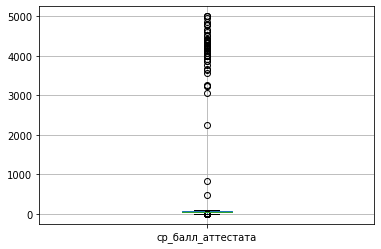

In [183]:
train.boxplot('ср_балл_аттестата')

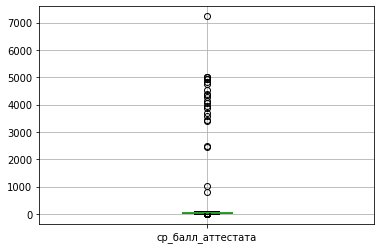

In [184]:
test.boxplot('ср_балл_аттестата')

In [185]:
def average_rating(row):
  if row <= 5:
    return row * 20
  else:
    return row

In [186]:
train['ср_балл_аттестата'] = train['ср_балл_аттестата'].apply(average_rating)
test['ср_балл_аттестата'] = test['ср_балл_аттестата'].apply(average_rating)

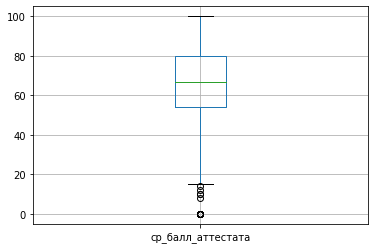

In [187]:
train.query('ср_балл_аттестата < 101').boxplot('ср_балл_аттестата')

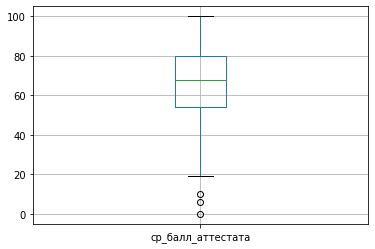

In [188]:
test.query('ср_балл_аттестата < 101').boxplot('ср_балл_аттестата')

In [189]:
train.query('ср_балл_аттестата < 101')['ср_балл_аттестата'].median()

67.0

In [190]:
test.query('ср_балл_аттестата < 101')['ср_балл_аттестата'].median()

68.0

In [191]:
def replace_estimation(row):
  if row < 20 or row > 100:
    return train.query('ср_балл_аттестата < 101')['ср_балл_аттестата'].median()
  else:
    return row

In [192]:
train['ср_балл_аттестата'] = train['ср_балл_аттестата'].apply(replace_estimation)
test['ср_балл_аттестата'] = test['ср_балл_аттестата'].apply(replace_estimation)

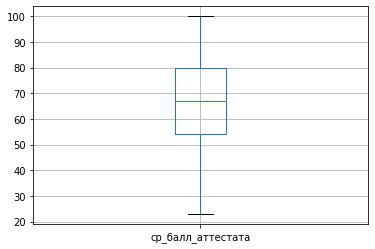

In [193]:
train.boxplot('ср_балл_аттестата')

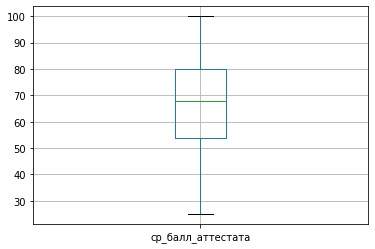

In [194]:
test.boxplot('ср_балл_аттестата')

In [195]:
train['ср_балл_аттестата'].describe()

count    13583.000000
mean        67.425237
std         16.793264
min         23.000000
25%         54.000000
50%         67.000000
75%         80.000000
max        100.000000
Name: ср_балл_аттестата, dtype: float64

In [196]:
test['ср_балл_аттестата'].describe()

count    6691.000000
mean       67.543993
std        16.727521
min        25.000000
25%        54.000000
50%        68.000000
75%        80.000000
max       100.000000
Name: ср_балл_аттестата, dtype: float64

# Новые признаки

In [197]:
train['возраст_окончания_уз'] = train['год_окончания_уз'] - train['год_рождения']
test['возраст_окончания_уз'] = test['год_окончания_уз'] - test['год_рождения']

In [198]:
train['возраст_при_поступлении'] = train['год_поступления'] - train['год_рождения']
test['возраст_при_поступлении'] = test['год_поступления'] - test['год_рождения']

In [199]:
def place_sch(df):
  place1 = df['где_находится_уз1']
  place2 = df['регион_пп']
  for i in range(len(df)):
    if place1[i] == place2[i]:
      return place1
    else:
      new_row = (place1[i] + ' ' + place2[i]).lower()
      return new_row.replace('unknow', '')


In [200]:
train['где_находится_уз1'] = place_sch(train)

In [201]:
test['где_находится_уз1'] = place_sch(test)

In [202]:
train.head()

,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,где_находится_уз1,город_пп_1,возраст_окончания_уз,возраст_при_поступлении
0,2015,жен,ОО,Английский язык,1998-02-08,школа,"Алтайский край, Барнаул г",2014,0,Россия,Алтайский край,0,0,0,Россия,0,0,0,41,85.88,3,1998,барнаул алтайский край,барнаул,16,17
1,2010,муж,ЦН,unknow,1992-04-18,unknow,unknow,2009,0,Россия,Алтайский край,0,1,1,Россия,0,0,0,28,67.00,4,1992,барнаул алтайский край,барнаул,17,18
2,2017,жен,ДН,Английский язык,1999-03-21,школа,"Алтайский край, Алтайский р-н, Алтайское с",2017,0,Россия,Алтайский край,0,1,1,Россия,0,0,0,41,82.66,4,1999,барнаул алтайский край,алтайское,18,18
3,2017,жен,БН,Английский язык,1994-12-08,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,0,1,1,Россия,0,0,0,35,74.00,4,1994,барнаул алтайский край,барнаул,23,23
4,2017,жен,БН,Английский язык,1995-06-28,университет,"Алтайский край, г. Барнаул",2017,0,Россия,Алтайский край,0,1,1,Россия,0,0,0,28,53.00,4,1995,барнаул алтайский край,барнаул,22,22


## возраст_при_поступлении

In [203]:
train['возраст_при_поступлении'].unique()

array([17, 18, 23, 22, 21, 16, 19, 30, 24, 36, 25, 20, 33, 47, 28, 29, 26,
       41, 31, 27, 37, 32, 38, 35, 48, 40, 43, 56, 45, 50, 58, 46, 34, 15,
       39, 42, 51, 71, 44, 61, 49,  2, 55, 53, 52,  1, 66, 65, 13, 54, 57,
        8, 12])

In [204]:
test['возраст_при_поступлении'].unique()

array([19, 20, 45, 32, 18, 23, 35, 22, 17, 16, 21, 25, 29, 40, 24, 27, 31,
       28, 30, 37, 26, 50, 33, 44, 43, 34, 36, 15, 52, 42, 38, 41, 39, 47,
       53, 67, 55, 48, 46, 56, 49, 57, 51, 59, 66, 12, 54, 58])

In [205]:
train[train['возраст_при_поступлении'] == 2]

,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,где_находится_уз1,город_пп_1,возраст_окончания_уз,возраст_при_поступлении
1470,2015,жен,ДН,Немецкий язык,2013-03-16,университет,"Алтайский край, Барнаул г",2015,1,Россия,Алтайский край,0,0,0,Россия,0,1,0,25,57.0,3,2013,барнаул алтайский край,елбанка,2,2


In [206]:
train.drop(train[train['возраст_при_поступлении'] == 1].index, inplace=True)
train.drop(train[train['возраст_при_поступлении'] == 2].index, inplace=True)

In [207]:
test.head(1)

,год_поступления,пол,основания,изучаемый_язык,дата_рождения,уч_заведение,где_находится_уз,год_окончания_уз,пособие,страна_пп,регион_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,год_рождения,где_находится_уз1,город_пп_1,возраст_окончания_уз,возраст_при_поступлении
0,2014,жен,ДН,Английский язык,1995-11-03,школа,"Алтайский край, Барнаул г",2014,0,Россия,Алтайский край,0,0,0,Россия,0,0,0,40,49.0,1995,барнаул алтайский край,барнаул,19,19


In [208]:
train.drop([#'год_поступления', 
            'дата_рождения',
            'где_находится_уз',
            #'год_окончания_уз',
            #'страна_пп',
            #'регион_пп',
            #'страна_родители',
            #'год_рождения',
            'где_находится_уз1',
            #'город_пп_1',
            #'возраст_окончания_уз',
            ], axis=1, inplace=True)
test.drop([#'год_поступления', 
            'дата_рождения',
            'где_находится_уз',
            #'год_окончания_уз',
            #'страна_пп',
            #'регион_пп',
            #'страна_родители',
            #'год_рождения',
            'где_находится_уз1',
            #'город_пп_1',
            #'возраст_окончания_уз',
           ], axis=1, inplace=True)

In [209]:
train.head(1)

,год_поступления,пол,основания,изучаемый_язык,уч_заведение,год_окончания_уз,пособие,страна_пп,регион_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,город_пп_1,возраст_окончания_уз,возраст_при_поступлении
0,2015,жен,ОО,Английский язык,школа,2014,0,Россия,Алтайский край,0,0,0,Россия,0,0,0,41,85.88,3,1998,барнаул,16,17


In [210]:
test.head(1)

,год_поступления,пол,основания,изучаемый_язык,уч_заведение,год_окончания_уз,пособие,страна_пп,регион_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,год_рождения,город_пп_1,возраст_окончания_уз,возраст_при_поступлении
0,2014,жен,ДН,Английский язык,школа,2014,0,Россия,Алтайский край,0,0,0,Россия,0,0,0,40,49.0,1995,барнаул,19,19


In [211]:
train['статус'].value_counts()

 4    8249
 3    4718
-1     614
Name: статус, dtype: int64

# Формирование наборов данных для обучения

In [212]:
train.head(1)

,год_поступления,пол,основания,изучаемый_язык,уч_заведение,год_окончания_уз,пособие,страна_пп,регион_пп,общежитие,наличие_матери,наличие_отца,страна_родители,опекунство,село,иностранец,код_факультета,ср_балл_аттестата,статус,год_рождения,город_пп_1,возраст_окончания_уз,возраст_при_поступлении
0,2015,жен,ОО,Английский язык,школа,2014,0,Россия,Алтайский край,0,0,0,Россия,0,0,0,41,85.88,3,1998,барнаул,16,17


In [213]:
cat_features = ['год_поступления',
                'пол',
                'основания',
                'изучаемый_язык',
                'уч_заведение',
                'год_окончания_уз',
                'пособие',
                'страна_пп',
                'регион_пп',
                'общежитие',
                'наличие_матери',
                'наличие_отца',
                'страна_родители',
                'опекунство',
                'село',
                'иностранец',
                'код_факультета',
                'город_пп_1',
                'возраст_окончания_уз',
                'возраст_при_поступлении',
                #'где_находится_уз1',
                'год_рождения'
               ]

for i in cat_features:
  train[i] = train[i].astype('category')
  test[i] = test[i].astype('category')


In [214]:
features = train.drop('статус', axis=1)
target = train['статус']

In [215]:
features_train, X_test, target_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1234)

# Cat_Boost

In [212]:
# Применим метод увеличения выборки

# Создадим функцию для увеличения выборки
def upsample(features, target, repeat_1, repeat_2):
    features_1 = features[target == -1]
    features_3 = features[target == 3]
    features_4 = features[target == 4]

    target_1 = target[target == -1]
    target_3 = target[target == 3]
    target_4 = target[target == 4]

    features_upsampled = pd.concat([features_1] * repeat_1 + [features_3] * repeat_2 + [features_4])#увеличим выборку с признаками
    target_upsampled = pd.concat([target_1] * repeat_1 + [target_3] * repeat_2 + [target_4])#увеличим выборку с целевым признаком
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)#перемешаем выборки
    
    return features_upsampled, target_upsampled

In [213]:
# Сформируем увеличенную выборку
features_upsampled, target_upsampled = upsample(features_train, target_train, 13, 2)

In [214]:
features_upsampled = features_upsampled.reset_index(drop=True)
target_upsampled = target_upsampled.reset_index(drop=True)

## Cat_Boost (почти на дефолных настройках)

In [215]:
cbc_model = CatBoostClassifier(loss_function='MultiClass',
                               random_state=12345,
                               verbose=False, 
                               cat_features=cat_features,
                               auto_class_weights='SqrtBalanced',
                               )


In [216]:
cbc_score = cross_val_score(cbc_model, features, target, scoring=make_scorer(f1_score, average='macro'), cv=5)
print('cbc_score: ', cbc_score.mean())

cbc_score:  0.6455235811474339


In [ ]:
tt = pd.read_csv('/content/sample_data/test_dataset_test.csv')
CB_model = cbc_model.fit(features, target)
pr = CB_model.predict(test)
pr = pr.tolist()
list_pred = []
for i in pr:
  list_pred.append(i[0])

df = pd.DataFrame({
    'ID': tt['ID'], 
    'Статус': list_pred
})


In [ ]:
df.to_csv('predicted_student_status_08.csv', index=False)

In [217]:
cbc_model.fit(features_train, target_train)
pred = cbc_model.predict(X_test)
f1_metr = f1_score(y_test, pred, average='macro')
f1_metr

0.6370137410582357

In [218]:
accuracy_metric = accuracy_score(y_test, pred)
accuracy_metric

0.7906360424028268

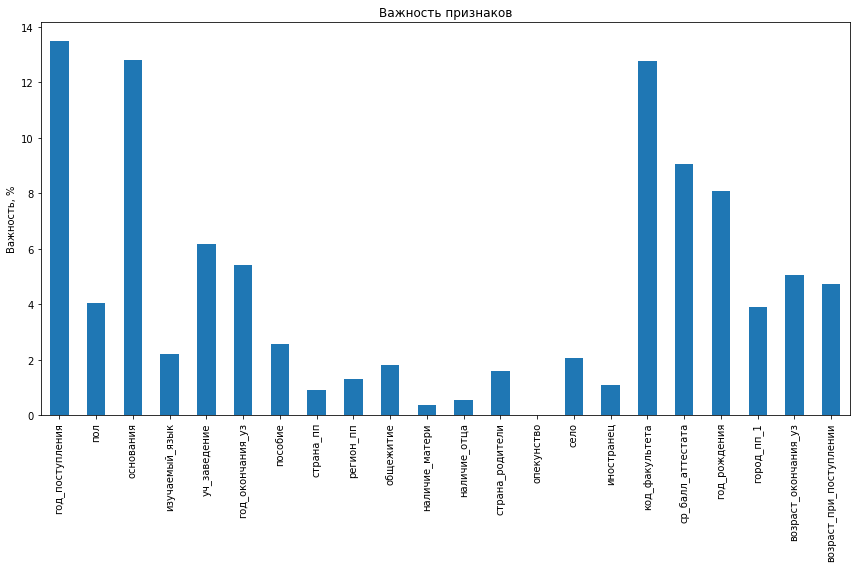

In [219]:
# Построим гистограмму для визуализации важности признаков
cat_train_imp = pd.Series(cbc_model.get_feature_importance(), features_train.columns)

fig, ax = plt.subplots(figsize=(12,8))
cat_train_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

## Cat_Boost + Optuna

In [216]:
def objective(trial, features=features_train, x_target=target_train):
    X_train, X_val, y_train, y_val = train_test_split(features, x_target, test_size=0.25, random_state=12345)

    params = {
        #'iterations': trial.suggest_int('iterations', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1.0]),
        'n_estimators': trial.suggest_int('n_estimators', 1, 70),
        'max_bin': trial.suggest_int('max_bin', 2, 30),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 5.0, log = True),
        #'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'random_seed': 12345,
        'loss_function':  trial.suggest_categorical('loss_function', ['MultiClass', 'MultiClassOneVsAll']),
        'custom_metric': 'F1',
        'auto_class_weights': 'SqrtBalanced',
    }
    
    model = CatBoostClassifier(**params, cat_features=cat_features,
                               verbose = False,
                               )
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 100)     
        
    #pred_train = model.predict(X_train)
    #f1_metric_train = f1_score(y_train, pred_train, average='macro')
    
    pred_val = model.predict(X_val)
    f1_metric_val = f1_score(y_val, pred_val, average='weighted')
    return f1_metric_val#/(abs(f1_metric_train - f1_metric_val))+1

In [217]:
study = optuna.create_study(direction = 'maximize', 
                            sampler=TPESampler()
                           )
study.optimize(objective, n_trials = 30)

display(f'Best value: {study.best_value}')
display(f'Best_params: {study.best_params}')

[I 2022-09-19 00:34:42,886] A new study created in memory with name: no-name-bfd9de9a-3235-4b4c-a9af-8c92214b89e5
[I 2022-09-19 00:34:43,120] Trial 0 finished with value: 0.6785231862171939 and parameters: {'max_depth': 5, 'learning_rate': 0.3, 'n_estimators': 3, 'max_bin': 3, 'min_data_in_leaf': 169, 'l2_leaf_reg': 0.0015802949164453338, 'loss_function': 'MultiClass'}. Best is trial 0 with value: 0.6785231862171939.
[I 2022-09-19 00:34:51,103] Trial 1 finished with value: 0.7302053203355258 and parameters: {'max_depth': 13, 'learning_rate': 0.8, 'n_estimators': 25, 'max_bin': 3, 'min_data_in_leaf': 141, 'l2_leaf_reg': 0.007606960409575331, 'loss_function': 'MultiClassOneVsAll'}. Best is trial 1 with value: 0.7302053203355258.
[I 2022-09-19 00:34:51,849] Trial 2 finished with value: 0.6474281111451405 and parameters: {'max_depth': 3, 'learning_rate': 0.0001, 'n_estimators': 36, 'max_bin': 24, 'min_data_in_leaf': 234, 'l2_leaf_reg': 0.568488562088466, 'loss_function': 'MultiClassOneVsAl

'Best value: 0.7549149159013923'

"Best_params: {'max_depth': 13, 'learning_rate': 0.1, 'n_estimators': 47, 'max_bin': 25, 'min_data_in_leaf': 190, 'l2_leaf_reg': 0.1184381287205415, 'loss_function': 'MultiClass'}"

In [218]:
optuna.visualization.plot_optimization_history(study)

In [219]:
reslt = {}
for i in notebook.tqdm(range(len(study.get_trials()))):
    if study.get_trials()[i].value > 0.74:
        model = CatBoostClassifier(**study.get_trials()[i].params, cat_features=cat_features, random_state=12345)  
        model.fit(features_train, target_train, verbose = False)

        pred_features_train = model.predict(features_train)
        f1_metric_features_train = f1_score(target_train, pred_features_train, average='macro')

        pred_test = model.predict(X_test)
        f1_metric_test = f1_score(pred_test, y_test, average='macro')
        
        
        reslt[i] = [study.get_trials()[i].value, f1_metric_features_train, f1_metric_test]

  0%|          | 0/30 [00:00<?, ?it/s]

In [220]:
reslt

{10: [0.7428740582088307, 0.552616085342145, 0.5348055950860235],
 13: [0.7491921128604349, 0.6442914878015237, 0.5526465732428848],
 16: [0.7520301118375904, 0.7068079786182965, 0.5706792616162868],
 17: [0.7549149159013923, 0.7031891306277046, 0.5627030648297733],
 18: [0.7495431886900135, 0.616184882020616, 0.5256487498025585],
 21: [0.7512110977292775, 0.6274901765839592, 0.5277653469931848],
 22: [0.7423600531646198, 0.5958983313997211, 0.5074580721961864],
 24: [0.7423073437353479, 0.5761644668211171, 0.5096878610271743],
 25: [0.7422956746536298, 0.762886626789841, 0.6009752336943383],
 26: [0.7427563155163099, 0.6609377439618057, 0.554618364644353],
 27: [0.7430654823220829, 0.6986928245573547, 0.5615935024696498],
 28: [0.7411516038745446, 0.5794807140161023, 0.5155370498148104]}

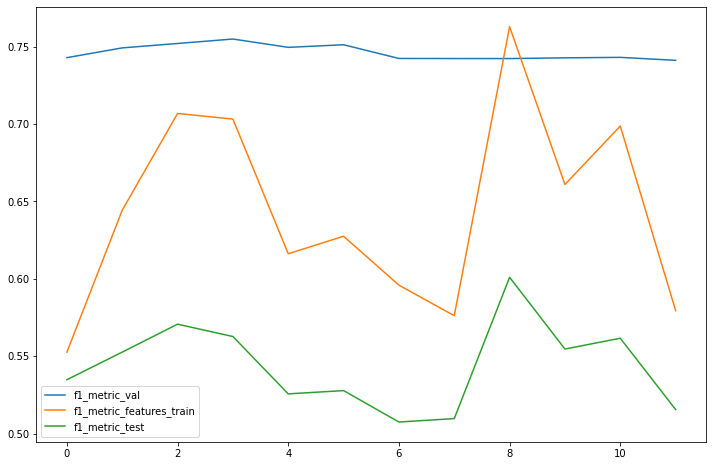

In [221]:
df_result = pd.DataFrame(list(reslt.values()), columns=['f1_metric_val', 'f1_metric_features_train', 'f1_metric_test'])
df_result.plot(figsize=(12, 8))

In [222]:
model = CatBoostClassifier(**study.get_trials()[25].params, cat_features=cat_features, random_state=12345)
model.fit(features_train, target_train, verbose = False)

pred_test = model.predict(X_test)
f1_metric_test = f1_score(y_test, pred_test, average='macro')

accuracy_metric = accuracy_score(y_test, pred_test)

display(f'accuracy_metric: {accuracy_metric}')
display(f'f1_metric: {f1_metric_test}')

'accuracy_metric: 0.7717903415783275'

'f1_metric: 0.6009752336943383'

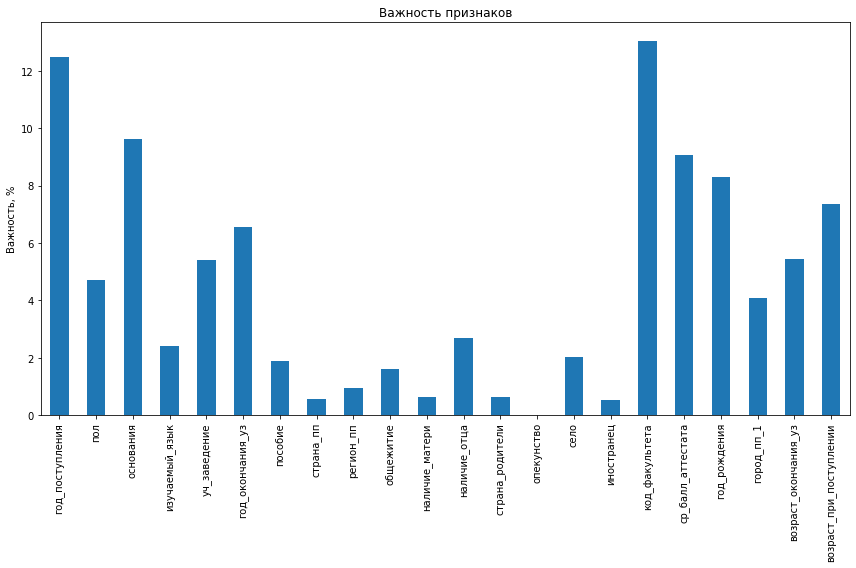

In [223]:
# Построим гистограмму для визуализации важности признаков
cat_train_imp = pd.Series(model.get_feature_importance(), features.columns)

fig, ax = plt.subplots(figsize=(12,8))
cat_train_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [224]:
sorted(cat_train_imp[cat_train_imp < 3])

[0.0,
 0.5333859911049199,
 0.5647809364120959,
 0.640756444870714,
 0.6454047270731192,
 0.9527329848318935,
 1.6001524352532608,
 1.896628364652954,
 2.0230015183818195,
 2.409106502223445,
 2.677316637808731]

In [225]:
cat_train_imp[cat_train_imp < 3].index

Index(['изучаемый_язык', 'пособие', 'страна_пп', 'регион_пп', 'общежитие',
       'наличие_матери', 'наличие_отца', 'страна_родители', 'опекунство',
       'село', 'иностранец'],
      dtype='object')

In [226]:
for i in cat_train_imp[cat_train_imp < 3].index:
  cat_features.remove(i)

features.drop(cat_train_imp[cat_train_imp < 3].index, axis=1, inplace=True)

In [227]:
cat_features

['год_поступления',
 'пол',
 'основания',
 'уч_заведение',
 'год_окончания_уз',
 'код_факультета',
 'город_пп_1',
 'возраст_окончания_уз',
 'возраст_при_поступлении',
 'год_рождения']

In [228]:
features_train, X_test, target_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)

In [230]:
def objective(trial, features=features_train, x_target=target_train):
    X_train, X_val, y_train, y_val = train_test_split(features, x_target, test_size=0.25, random_state=12345)

    params = {
        #'iterations': trial.suggest_int('iterations', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1.0]),
        'n_estimators': trial.suggest_int('n_estimators', 1, 70),
        'max_bin': trial.suggest_int('max_bin', 2, 30),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 5.0, log = True),
        #'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'random_seed': 12345,
        'loss_function':  trial.suggest_categorical('loss_function', ['MultiClass', 'MultiClassOneVsAll']),
        'custom_metric': 'F1',
        'auto_class_weights': 'SqrtBalanced',
    }
    
    model = CatBoostClassifier(**params, cat_features=cat_features,
                               verbose = False,
                               )
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 100)     
        
    #pred_train = model.predict(X_train)
    #f1_metric_train = f1_score(y_train, pred_train, average='macro')
    
    pred_val = model.predict(X_val)
    f1_metric_val = f1_score(y_val, pred_val, average='macro')
    return f1_metric_val#/(abs(f1_metric_train - f1_metric_val))+1

In [231]:
study = optuna.create_study(direction = 'maximize', 
                            sampler=TPESampler()
                           )
study.optimize(objective, n_trials = 30)

display(f'Best value: {study.best_value}')
display(f'Best_params: {study.best_params}')

[I 2022-09-19 00:50:34,624] A new study created in memory with name: no-name-051cd997-efdd-44ab-992f-2e7789f85336
[I 2022-09-19 00:50:35,722] Trial 0 finished with value: 0.5620862544622973 and parameters: {'max_depth': 7, 'learning_rate': 0.05, 'n_estimators': 39, 'max_bin': 9, 'min_data_in_leaf': 8, 'l2_leaf_reg': 1.2274579986262195, 'loss_function': 'MultiClass'}. Best is trial 0 with value: 0.5620862544622973.
[I 2022-09-19 00:50:36,125] Trial 1 finished with value: 0.564538186448226 and parameters: {'max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 36, 'max_bin': 24, 'min_data_in_leaf': 185, 'l2_leaf_reg': 0.0007350485346006802, 'loss_function': 'MultiClass'}. Best is trial 1 with value: 0.564538186448226.
[I 2022-09-19 00:50:36,683] Trial 2 finished with value: 0.5815025743098466 and parameters: {'max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 42, 'max_bin': 14, 'min_data_in_leaf': 227, 'l2_leaf_reg': 0.009956070684493072, 'loss_function': 'MultiClass'}. Best is trial 2

'Best value: 0.5945302478166573'

"Best_params: {'max_depth': 7, 'learning_rate': 0.5, 'n_estimators': 30, 'max_bin': 19, 'min_data_in_leaf': 241, 'l2_leaf_reg': 0.0005002638976873517, 'loss_function': 'MultiClassOneVsAll'}"

In [232]:
optuna.visualization.plot_optimization_history(study)

In [233]:
reslt = {}
for i in notebook.tqdm(range(len(study.get_trials()))):
    if study.get_trials()[i].value > 0.57:
        model = CatBoostClassifier(**study.get_trials()[i].params, cat_features=cat_features, random_state=12345)  
        model.fit(features_train, target_train, verbose = False)

        pred_features_train = model.predict(features_train)
        f1_metric_features_train = f1_score(target_train, pred_features_train, average='macro')

        pred_test = model.predict(X_test)
        f1_metric_test = f1_score(pred_test, y_test, average='macro')

        
        
        reslt[i] = [study.get_trials()[i].value, f1_metric_features_train, f1_metric_test]

  0%|          | 0/30 [00:00<?, ?it/s]

In [234]:
reslt

{2: [0.5815025743098466, 0.5905864523759985, 0.5558380595140361],
 10: [0.5805240156506167, 0.633208900024533, 0.559128035989043],
 11: [0.5849453188723859, 0.6354952587151682, 0.5626900933094069],
 17: [0.5794619205300887, 0.49690483756025744, 0.4856369952848034],
 20: [0.5897420808255535, 0.6136179167854907, 0.5369407034768825],
 21: [0.5811967725988464, 0.602076277333737, 0.5476904494219466],
 22: [0.5828098767274024, 0.6069060565494729, 0.5436960560259295],
 25: [0.5801131337521326, 0.536882581378814, 0.503913868228658],
 26: [0.5945302478166573, 0.6320695492317163, 0.555435591822231],
 27: [0.5889787649550071, 0.5921408679489392, 0.5393704590146814],
 28: [0.5945302478166573, 0.6343398831013927, 0.5567400501867413],
 29: [0.5945302478166573, 0.6331037246658667, 0.5562835618579507]}

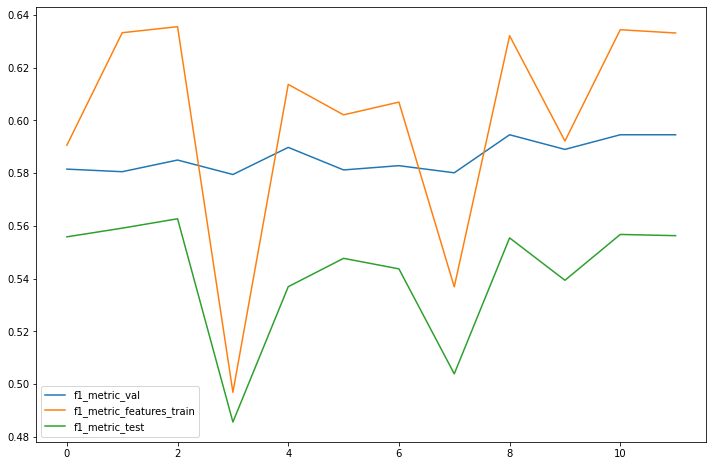

In [235]:
df_result = pd.DataFrame(list(reslt.values()), columns=['f1_metric_val', 'f1_metric_features_train', 'f1_metric_test'])
df_result.plot(figsize=(12, 8))

In [236]:
model = CatBoostClassifier(**study.get_trials()[11].params, cat_features=cat_features, random_state=12345)
model.fit(features_train, target_train, verbose = False)

pred_test = model.predict(X_test)
f1_metric_test = f1_score(y_test, pred_test, average='macro')

accuracy_metric = accuracy_score(y_test, pred_test)

display(f'accuracy_metric: {accuracy_metric}')
display(f'f1_metric: {f1_metric_test}')

'accuracy_metric: 0.7563489142436511'

'f1_metric: 0.5626900933094069'

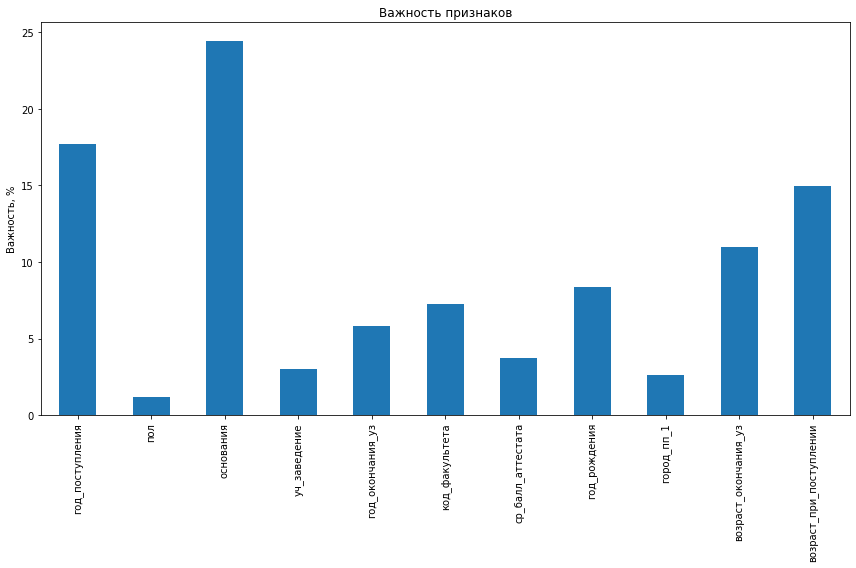

In [237]:
# Построим гистограмму для визуализации важности признаков
cat_train_imp = pd.Series(model.get_feature_importance(), features.columns)

fig, ax = plt.subplots(figsize=(12,8))
cat_train_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [ ]:

pr = cbc_model.predict(test)
pr = pr.tolist()
list_pred = []
for i in pr:
  list_pred.append(i[0])

df = pd.DataFrame({
    'ID': tt['ID'], 
    'Статус': list_pred
})
df.to_csv('predicted_student_status_07.csv', index=False)

CatBoostError: ignored

# KERAS

In [ ]:
s = pd.get_dummies(target)
target_dum = pd.merge(target, s, left_index=True, right_index=True)
target_dum.drop('статус', axis=1, inplace=True)

In [ ]:
columns_name = list(features.columns)
columns_name.remove('ср_балл_аттестата')

In [ ]:
columns_name = list(features.columns)
columns_name.remove('ср_балл_аттестата')
for column in columns_name:
  e = pd.get_dummies(features[column],drop_first=True)
  features = pd.merge(features, e, left_index=True,right_index=True)
  features.drop(column, axis=1, inplace=True)

In [ ]:
features.head()

,ср_балл_аттестата,жен,муж,ДН,ОО,СН,ЦН,Английский язык,Немецкий язык,Русский язык,Французский язык,академия,гимназия,институт,колледж,лицей,техникум,университет,училище,школа,1,1_x,1_y,Армения,Германия,КНР,Казахстан,Китай,Кыргызстан,Монголия,Нигерия,Республика Молдова,Россия,Таджикистан,Туркменистан,Узбекистан,Украина,25_x,26_x,27_x,28_x,30_x,31_x,34_x,35_x,36_x,37_x,40_x,41_x,45_x,46_x,47_x,48_x,49_x,51_x,53_x,-,10 лет октября,12 лет октября,3 интернационал,unknow,а жаны-куч,а казыбек,абай,абакан,авловск,айхал,ак-довурак,акимовка,аксу,акташ,актобе,акулово,алдан,алейск,алейский,александровка,алексеевка,аллак,алматы,алмоси,алтай,алтайское,алхан-кала,амур,анадырь,андреевка,андроново,анжеро-судженск,анисимово,антипино,антоньевка,аньян,арбузовка,армавир,артемовский,артыбаш,ас,аскиз,астана,асямовка,атай,ауэзова,ахмет,ачинск,ая,б-енисейское,баево,бажево,бай-хаак,балакино,балбай,балыктуюль,балыкча,балыхча,барагаш,барановка,барнаул,барчиха,бачжун,баштала,баюновские ключи,ббуньково,безголосово,безменово,безрукавка,белово,беловский,белоглазово,белокуриха,белорецк,белояровка,беляши,бердск,березка,березовка,березовский,беспаловский,бийск,бирюля,бишкек,благовещенка,бобково,бобровка,болотное,большая талда,большепанюшево,большеромановка,большеугренево,большой калтай,боочи,бор-форпост,бора-тайга,борзовая заимка,борисово,бориха,боровиха,боровлянка,боровое,боровой,боровское,бородулиха,боронский,бочкари,брагино,братск,брусенцево,будинобод,буканское,буланиха,булбулчашма кишлак,буньково,бурановка,бураново,бурганды,бурея,бурла,буян,быструха,быстрый исток,быстрянка,в-суетка,вавилон,ванцин,васильевка,васильчуки,вахдат,велижанка,верх-аллак,верх-березовка,верх-бехтемир,верх-жилино,верх-кажа,верх-камышенка,верх-катунское,верх-кучук,верх-мута,верх-неня,верх-обский,верх-озерное,верх-пайва,верх-слюдянка,верх-суетка,верх-сузун,верх-уймон,верх-ябоган,верх-яминское,веселоярск,видоново,вилючинск,власиха,воеводское,воздвиженка,вознесенка,волчанка,волчиха,волчно-бурлинское,ворониха,воскресенка,восточный,вострово,выдриха,вылково,высокая грива,вэнчан,вэньчан,вяткино,вячеславка,галлаобод джамоат,гальбштадт,георгиевка,гилев-лог,гилевка,гилево,гисар,гиссар,глубокое,глушинка,глядень,глядень-1,голышево,гонохово,гоньба,гор округ цзиньчан,горбуново,гордеевский,горки,горно-алтайск,горный,горняк,городецкий,горьковское,гришковка,грязново,гуангжоу,гуанхань,гуанчжоу,гунчжулин,гуселетово,гусиноозерск,дальний,дальянь,далян,далянь,дангара,даньчжоу,дачжоу,дебин,дегтярка,дж г шахбозов,джамоат сабо,"джзайнабобод, с садокат",джрашен,дмитриевка,дмитро-титово,догланка,долганка,долгово,долинка,долинское,долонь,доль,донгора,донецк,дружба,дубровино,дудинка,думчево,дунган,душанбе,"душанбе г, гиссар р-н","душанбе г, зарафшан",егорьевский,екатеринбург,екатерининское,екатериновка,елбанка,елунино,ельцовка,енисейское,ерейментау,есик,жалал абад,жалал-абад,жана-аул,жаны-жер,жаохэ,жезкент,железинка,железногорск,жергетал,жесткент,жилино,жоош,жуланиха,журавлиха,заветы ильича,заводское,заводской,завьялово,загайново,зайцево,закладное,заковряшино,залари,залесово,западный угол,заречное,заречный,заринск,заря,зафарабад,зеленая поляна,зеленоград,зеленый дол,зима,зимари,зимино,зимник,златополь,златоуст,змеиногорск,знаменка,золотуха,зональное,зудилово,зырянка,зыряновск,ивановка,ильинка,им калинина,им мамонтова,инин,инкоу,инта,иня,иогач,иркутск,искитим,искра,истаравшан,истимис,исфана,исфара,ичунь,ишимбай,йонко,каа-хем,кабаково,кадамжай,казарма 519 км,казачий,казенная заимка,казыбек,каип,кайырма-арык,калиновка,калистратиха,калманка,калмыцкие мысы,калтан,каменушка,камень-на-оби,камышенка,камыши,камышинка,канибадам,канонерка,канск,карабинка,карагай,караганда,каракокша,каракол,карамышево,карасук,караул,каркавино,карловка,карлушка,карпово,карпово второе,карповский,каскелен,касли,касмалинка,катайск,катанда,катунское,катунь,качусово,кашино,кашкар,кашкарагаиха,каярлык,каяушка,каяшкан,кебезень,кемерово,кибраи,киприно,кирей,кировский,киселевск,кисилевск,кичек,клепечиха,клепиково,клочки,ключи,ключики,кокорский,коктобе,

In [ ]:
len(features.columns)

1266

In [ ]:
features_set = features.values
target_dum_set = target_dum.values

In [ ]:
features_dum, X_test_dum, target_dum, y_test_dum = train_test_split(features_set, target_dum_set, test_size=0.25, random_state=1)

In [ ]:
optimizer = Adam()
optimizer = Adam(lr=0.0001)

In [ ]:
model_ker = keras.models.Sequential()
model_ker.add(keras.layers.Dense(units=1266, input_dim=features_dum.shape[1], activation='relu'))
#model_ker.add(keras.layers.Dense(units=1497, input_dim=features_dum.shape[1], activation='relu'))
#model_ker.add(keras.layers.Dense(units=1497, input_dim=features_dum.shape[1], activation='relu'))
#model_ker.add(keras.layers.Dense(units=1497, input_dim=features_dum.shape[1], activation='relu'))
#model_ker.add(keras.layers.Dense(units=1497, input_dim=features_dum.shape[1], activation='relu'))
#model_ker.add(keras.layers.Dense(units=1497, input_dim=features_dum.shape[1], activation='relu'))
#model_ker.add(keras.layers.Dense(units=24, input_dim=features_dum.shape[1], activation='relu'))
model_ker.add(keras.layers.Dense(units=3, input_dim=features_dum.shape[1], activation='softmax'))
model_ker.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])


In [ ]:
model_ker.fit(features_dum, target_dum, validation_data=(X_test_dum, y_test_dum), epochs=20, verbose=2)

Epoch 1/20
319/319 - 5s - loss: 0.8079 - acc: 0.6124 - val_loss: 0.7536 - val_acc: 0.6396 - 5s/epoch - 15ms/step
Epoch 2/20
319/319 - 4s - loss: 0.7206 - acc: 0.6753 - val_loss: 0.7332 - val_acc: 0.6826 - 4s/epoch - 13ms/step
Epoch 3/20
319/319 - 4s - loss: 0.7001 - acc: 0.6916 - val_loss: 0.7059 - val_acc: 0.7002 - 4s/epoch - 13ms/step
Epoch 4/20
319/319 - 4s - loss: 0.6846 - acc: 0.7009 - val_loss: 0.6993 - val_acc: 0.7020 - 4s/epoch - 13ms/step
Epoch 5/20
319/319 - 4s - loss: 0.6728 - acc: 0.7040 - val_loss: 0.7287 - val_acc: 0.6714 - 4s/epoch - 13ms/step
Epoch 6/20
319/319 - 4s - loss: 0.6681 - acc: 0.7054 - val_loss: 0.7057 - val_acc: 0.6790 - 4s/epoch - 13ms/step
Epoch 7/20
319/319 - 4s - loss: 0.6571 - acc: 0.7114 - val_loss: 0.6871 - val_acc: 0.7049 - 4s/epoch - 13ms/step
Epoch 8/20
319/319 - 4s - loss: 0.6522 - acc: 0.7126 - val_loss: 0.6893 - val_acc: 0.6949 - 4s/epoch - 13ms/step
Epoch 9/20
319/319 - 4s - loss: 0.6435 - acc: 0.7215 - val_loss: 0.6791 - val_acc: 0.7076 - 4s/e

In [ ]:
pred_test = model_ker.predict(X_test_dum)
pred_test



In [ ]:
y_test_dum

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)